In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from itertools import product
import seaborn as sns

from utils.data_acquisition import  fetch_housing_dataset, fetch_wine_dataset
from utils.metrics import mse, accuracy_score, precision_score, recall_score, f1_score
from utils.data_preparation import remove_outliers, min_max_scale, k_fold_split
from models.models import LinearRegression, LogisticRegression
from models.optimizers import GradientDescent, StochasticGradientDescent

In [3]:
plt.rcParams["figure.dpi"] = 400

## Data Loading


In [4]:
SEED = 42
np.random.seed(SEED)

HOUSING_DF = fetch_housing_dataset()
WINE_DF = fetch_wine_dataset()

# shuffle 
HOUSING_DF = HOUSING_DF.sample(frac=1, random_state=SEED).reset_index(drop=True)
WINE_DF = WINE_DF.sample(frac=1, random_state=SEED).reset_index(drop=True)



# Experiment 1: Basic Performance Comparison

For both datasets, perform an 80/20 train/test split and report the performance metrics on both the training set and test set for each model. Please include metrics such as Mean Squared Error (MSE) for Linear Regression and accuracy, precision, recall, and F1-score for Logistic Regression

### Data Preparation

In [3]:
TEST_SIZE = 0.2
IQR_FACTOR = 1.5

housing_df = HOUSING_DF.copy()
wine_df = WINE_DF.copy()

### Data Cleaning ###
# remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)

### Data Splitting ###
# perform train test split
X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), 
                                                                                    test_size=TEST_SIZE, random_state=SEED)

one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(),
                                                                        one_hot_wine_classes, test_size=TEST_SIZE, random_state=SEED)

### Data Normalization ###
# normalize data after train test split to prevent data leakage
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test)
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)

### Linear Regression

Analytic Fit:
Train Error:  6.775670736414897
Test Error:  6.179342867963817
SGD Fit:
Train Error:  14.262232369971366
Test Error:  9.854699307781145


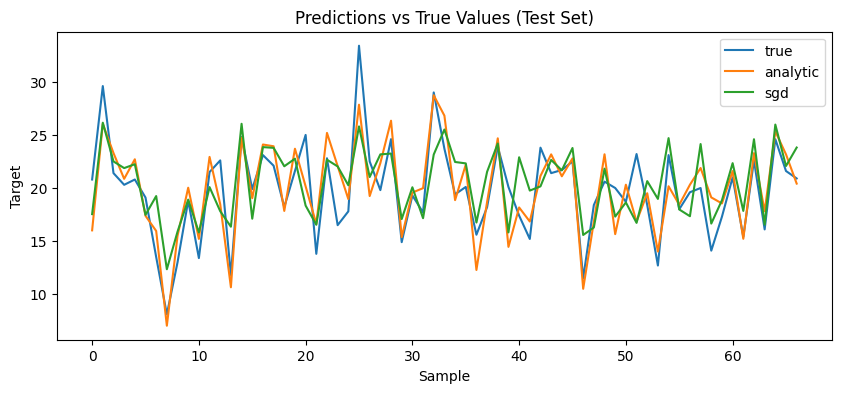

In [12]:
OPTIMIZER_KWARGS = {
    'batch_size': 32,
    'learning_rate': 0.1,
    'max_iters': 1e5,
    'verbose': False
}

# analytic fit
lin_reg = LinearRegression()
lin_reg.fit(X_housing_train, y_housing_train, analytic_fit=True, verbose=False)
y_preds_analytic = lin_reg.predict(X_housing_test)
error_analytic_train =  mse(y_housing_train, lin_reg.predict(X_housing_train))
error_analytic_test = mse(y_housing_test, y_preds_analytic)
w_analytic = np.copy(lin_reg.w)

# mini-batch SGD fit
log_reg = LogisticRegression()
lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
error_sgd_train =  mse(y_housing_train, lin_reg.predict(X_housing_train))
y_preds_sgd= lin_reg.predict(X_housing_test)
error_sgd_test = mse(y_housing_test, y_preds_sgd)


### Results ###
print('Analytic Fit:')
print('Train Error: ', error_analytic_train)
print('Test Error: ', error_analytic_test)
print('SGD Fit:')
print('Train Error: ', error_sgd_train)
print('Test Error: ', error_sgd_test)

plt.figure(figsize=(10,4))
plt.plot(y_housing_test, label='true')
plt.plot(y_preds_analytic, label='analytic')
plt.plot(y_preds_sgd, label='sgd')
plt.title('Predictions vs True Values (Test Set)')
plt.xlabel('Sample')
plt.ylabel('Target')
plt.legend()
plt.show()

### Logistic Regression

In [7]:
BATCH_SIZE = 32
OPTIMIZER_KWARGS = {
    'max_iters': 1e5,
    'learning_rate': 0.1,
    'verbose': False
    }

metrics = ['accuracy', 'precision', 'recall', 'f1']
results = {metric: {'gd_train': 0, 'gd_test': 0, 'sgd_train': 0, 'sgd_test': 0} for metric in metrics}

# GD fit
log_reg = LogisticRegression()
log_reg.fit(X_wine_train, y_wine_train, optimizer_class=GradientDescent, **OPTIMIZER_KWARGS)
y_wine_train_preds_gd = log_reg.predict(X_wine_train)
y_wine_preds_gd = log_reg.predict(X_wine_test)
w_gd = np.copy(log_reg.w)


# mini-batch SGD fit
log_reg = LogisticRegression()
log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, batch_size=BATCH_SIZE, **OPTIMIZER_KWARGS)
y_wine_train_preds_sgd = log_reg.predict(X_wine_train)
y_wine_preds_sgd = log_reg.predict(X_wine_test)
w_sgd = np.copy(log_reg.w)

for metric, metric_func in zip(metrics, [accuracy_score, precision_score, recall_score, f1_score]):
    results[metric]['gd_train'] = metric_func(y_wine_train, y_wine_train_preds_gd)
    results[metric]['gd_test'] = metric_func(y_wine_test, y_wine_preds_gd)
    results[metric]['sgd_train'] = metric_func(y_wine_train, y_wine_train_preds_sgd)
    results[metric]['sgd_test'] = metric_func(y_wine_test, y_wine_preds_sgd)

for metric in metrics:
    print(f'{metric}:\nGD Train: {results[metric]["gd_train"]}\nGD Test: {results[metric]["gd_test"]}\nSGD Train: {results[metric]["sgd_train"]}\nSGD Test: {results[metric]["sgd_test"]}\n')

accuracy:
GD Train: 0.9453125
GD Test: 0.9696969696969697
SGD Train: 0.953125
SGD Test: 0.9393939393939394

precision:
GD Train: 0.9472768273976258
GD Test: 0.9722222222222221
SGD Train: 0.9581473214285714
SGD Test: 0.9487179487179487

recall:
GD Train: 0.9453125
GD Test: 0.9696969696969697
SGD Train: 0.953125
SGD Test: 0.9393939393939394

f1:
GD Train: 0.9447268740031898
GD Test: 0.9695582830594272
SGD Train: 0.9534894075416367
SGD Test: 0.9385521885521886



### Results

**Linear Regression**
- analytical solution of linear regression performs much better (6 vs 12 MSE)

**Logistic Regression**
- Logistic Regression performs really well on the data
- SGD works better than GD with BS 64
- with BS 8, SGD performs worse than GD

# Experiment 2: Cross-Validation

For both data sets, use a 5-fold cross-validation technique and report the performance metrics on both the training set and test set for each model. Again, include appropriate performance metrics for each model. Check this link for more information.

Note: 5-fold cross-validation is a technique where the dataset is divided into five equal parts (folds), and a model is trained and evaluated five times, each time using a different fold as the validation set and the remain- ing four folds for training.


### Data Preparation

In [10]:
IQR_FACTOR = 1.5

housing_df = HOUSING_DF.copy()
wine_df = WINE_DF.copy()

### Data Cleaning ###
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)

X_housing = housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy()
y_housing = housing_df_cleaned.MEDV.to_numpy().reshape(-1,1)

X_wine = wine_df_cleaned.drop(['class'], axis=1).to_numpy()
y_wine = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)

### Linear Regression

In [11]:
OPTIMIZER_KWARGS = {
    'batch_size': 32,
    'learning_rate': 0.1,
    'max_iters': 1e5,
    'verbose': False
}

errors_analytic_train = []
errors_analytic_test = []
errors_sgd_train = []
errors_sgd_test = []

for X_train_fold, y_train_fold, X_test_fold, y_test_fold in k_fold_split(X_housing, y_housing, n_splits=5):

    # data normalization
    X_train_fold, X_test_fold = min_max_scale(X_train_fold, X_test_fold)

    # analytic fit
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_fold, y_train_fold, analytic_fit=True, verbose=False)
    y_preds_with_analytic_fit_train = lin_reg.predict(X_train_fold)
    y_preds_with_analytic_fit_test = lin_reg.predict(X_test_fold)
    errors_analytic_train.append(mse(y_train_fold, y_preds_with_analytic_fit_train))
    errors_analytic_test.append(mse(y_test_fold, y_preds_with_analytic_fit_test))
    w_analytic = np.copy(lin_reg.w)

    # mini-batch SGD fit
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_fold, y_train_fold, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
    y_preds_with_grad_train = lin_reg.predict(X_train_fold)
    y_preds_with_grad_test = lin_reg.predict(X_test_fold)
    errors_sgd_train.append(mse(y_train_fold, y_preds_with_grad_train))
    errors_sgd_test.append(mse(y_test_fold, y_preds_with_grad_test))

print("Analytic Fit Errors:")
print("Train Mean:", np.mean(errors_analytic_train))
print("Train Std:", np.std(errors_analytic_train))
print("Test Mean:", np.mean(errors_analytic_test))
print("Test Std:", np.std(errors_analytic_test))

print("\nMini-Batch SGD Errors:")
print("Train Mean:", np.mean(errors_sgd_train))
print("Train Std:", np.std(errors_sgd_train))
print("Test Mean:", np.mean(errors_sgd_test))
print("Test Std:", np.std(errors_sgd_test))

Analytic Fit Errors:
Train Mean: 6.518268899319205
Train Std: 0.2921156084743881
Test Mean: 7.062425720000242
Test Std: 1.1400669163637824

Mini-Batch SGD Errors:
Train Mean: 13.195129323497659
Train Std: 0.25717607996455616
Test Mean: 13.643554936702325
Test Std: 1.0254426372434107


### Logistic Regression

In [8]:
BATCH_SIZE = 32
OPTIMIZER_KWARGS = {
    'max_iters': 4e4,
    'learning_rate': 0.1,
    'verbose': False
    }

# init result lists
metrics = ['accuracy', 'precision', 'recall', 'f1']
results = {metric: {'gd_train': [], 'gd_test': [], 'sgd_train': [], 'sgd_test': []} for metric in metrics}

for X_train_fold, y_train_fold, X_test_fold, y_test_fold in k_fold_split(X_wine, y_wine):

    # GD fit
    log_reg = LogisticRegression()
    log_reg.fit(X_train_fold, y_train_fold, optimizer_class=GradientDescent, **OPTIMIZER_KWARGS)

    # GD metrics
    y_train_preds_gd = log_reg.predict(X_train_fold)
    y_test_preds_gd = log_reg.predict(X_test_fold)

    for metric, metric_func in zip(metrics, [accuracy_score, precision_score, recall_score, f1_score]):
        if metric_func.__name__ == 'recall_score':
            results[metric]['gd_train'].append(metric_func(y_train_fold, y_train_preds_gd))
            results[metric]['gd_test'].append(metric_func(y_test_fold, y_test_preds_gd))
        else:
            results[metric]['gd_train'].append(metric_func(y_train_fold, y_train_preds_gd))
            results[metric]['gd_test'].append(metric_func(y_test_fold, y_test_preds_gd))

    # mini-batch SGD fit
    log_reg = LogisticRegression()
    log_reg.fit(X_train_fold, y_train_fold, optimizer_class=StochasticGradientDescent, batch_size=BATCH_SIZE, **OPTIMIZER_KWARGS)

    # SGD metrics
    y_train_preds_sgd = log_reg.predict(X_train_fold)
    y_test_preds_sgd = log_reg.predict(X_test_fold)
    for metric, metric_func in zip(metrics, [accuracy_score, precision_score, recall_score, f1_score]):
        results[metric]['sgd_train'].append(metric_func(y_train_fold, y_train_preds_sgd))
        results[metric]['sgd_test'].append(metric_func(y_test_fold, y_test_preds_sgd))

# compute mean and std for each metric
for metric in metrics:
    print(f"{metric.capitalize()} Results:")
    for key, values in results[metric].items():
        print(f"{key.replace('_', ' ').capitalize()}: Mean {np.mean(values).round(5)}, Std {np.std(values).round(5)}")
    print()  

Accuracy Results:
Gd train: Mean 0.93477, Std 0.01743
Gd test: Mean 0.90076, Std 0.02261
Sgd train: Mean 0.92857, Std 0.03682
Sgd test: Mean 0.91288, Std 0.03671

Precision Results:
Gd train: Mean 0.9404, Std 0.01368
Gd test: Mean 0.91453, Std 0.01436
Sgd train: Mean 0.93294, Std 0.03063
Sgd test: Mean 0.91699, Std 0.03268

Recall Results:
Gd train: Mean 0.93477, Std 0.01743
Gd test: Mean 0.90076, Std 0.02261
Sgd train: Mean 0.92857, Std 0.03682
Sgd test: Mean 0.91288, Std 0.03671

F1 Results:
Gd train: Mean 0.93347, Std 0.01825
Gd test: Mean 0.89895, Std 0.02391
Sgd train: Mean 0.92684, Std 0.03975
Sgd test: Mean 0.91248, Std 0.03716



### Results

**Linear Regression**
- anayltic performs better
- both analytic and SGD have std on test set around 5

**Logistic Regression**
- looks a bit like overfitting
- high standard deviation on test set performance

# Experiment 3: Training Set Sizes
For both datasets, Sample growing subsets of the training data (20%,30%,...80%). Observe and explain how does size of training data affects the performance for both models. Plot two curves as a function of training size, one for performance in train and one for test.

### Data Preparation

In [55]:
TEST_SIZE = 0.2
IQR_FACTOR = 1.5
SEED=1
housing_df = HOUSING_DF.copy()
wine_df = WINE_DF.copy()

### Data Cleaning ###
# remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df_cleaned, factor=IQR_FACTOR)


### Data Splitting ###
# perform train test split
one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(), 
                                                                        one_hot_wine_classes, test_size=TEST_SIZE, random_state=SEED)

X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), 
                                                                                    test_size=TEST_SIZE, random_state=SEED)

### Data Normalization ###
# normalize data after train test split to prevent data leakage
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test, scale=True)
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)

### Linear Regression

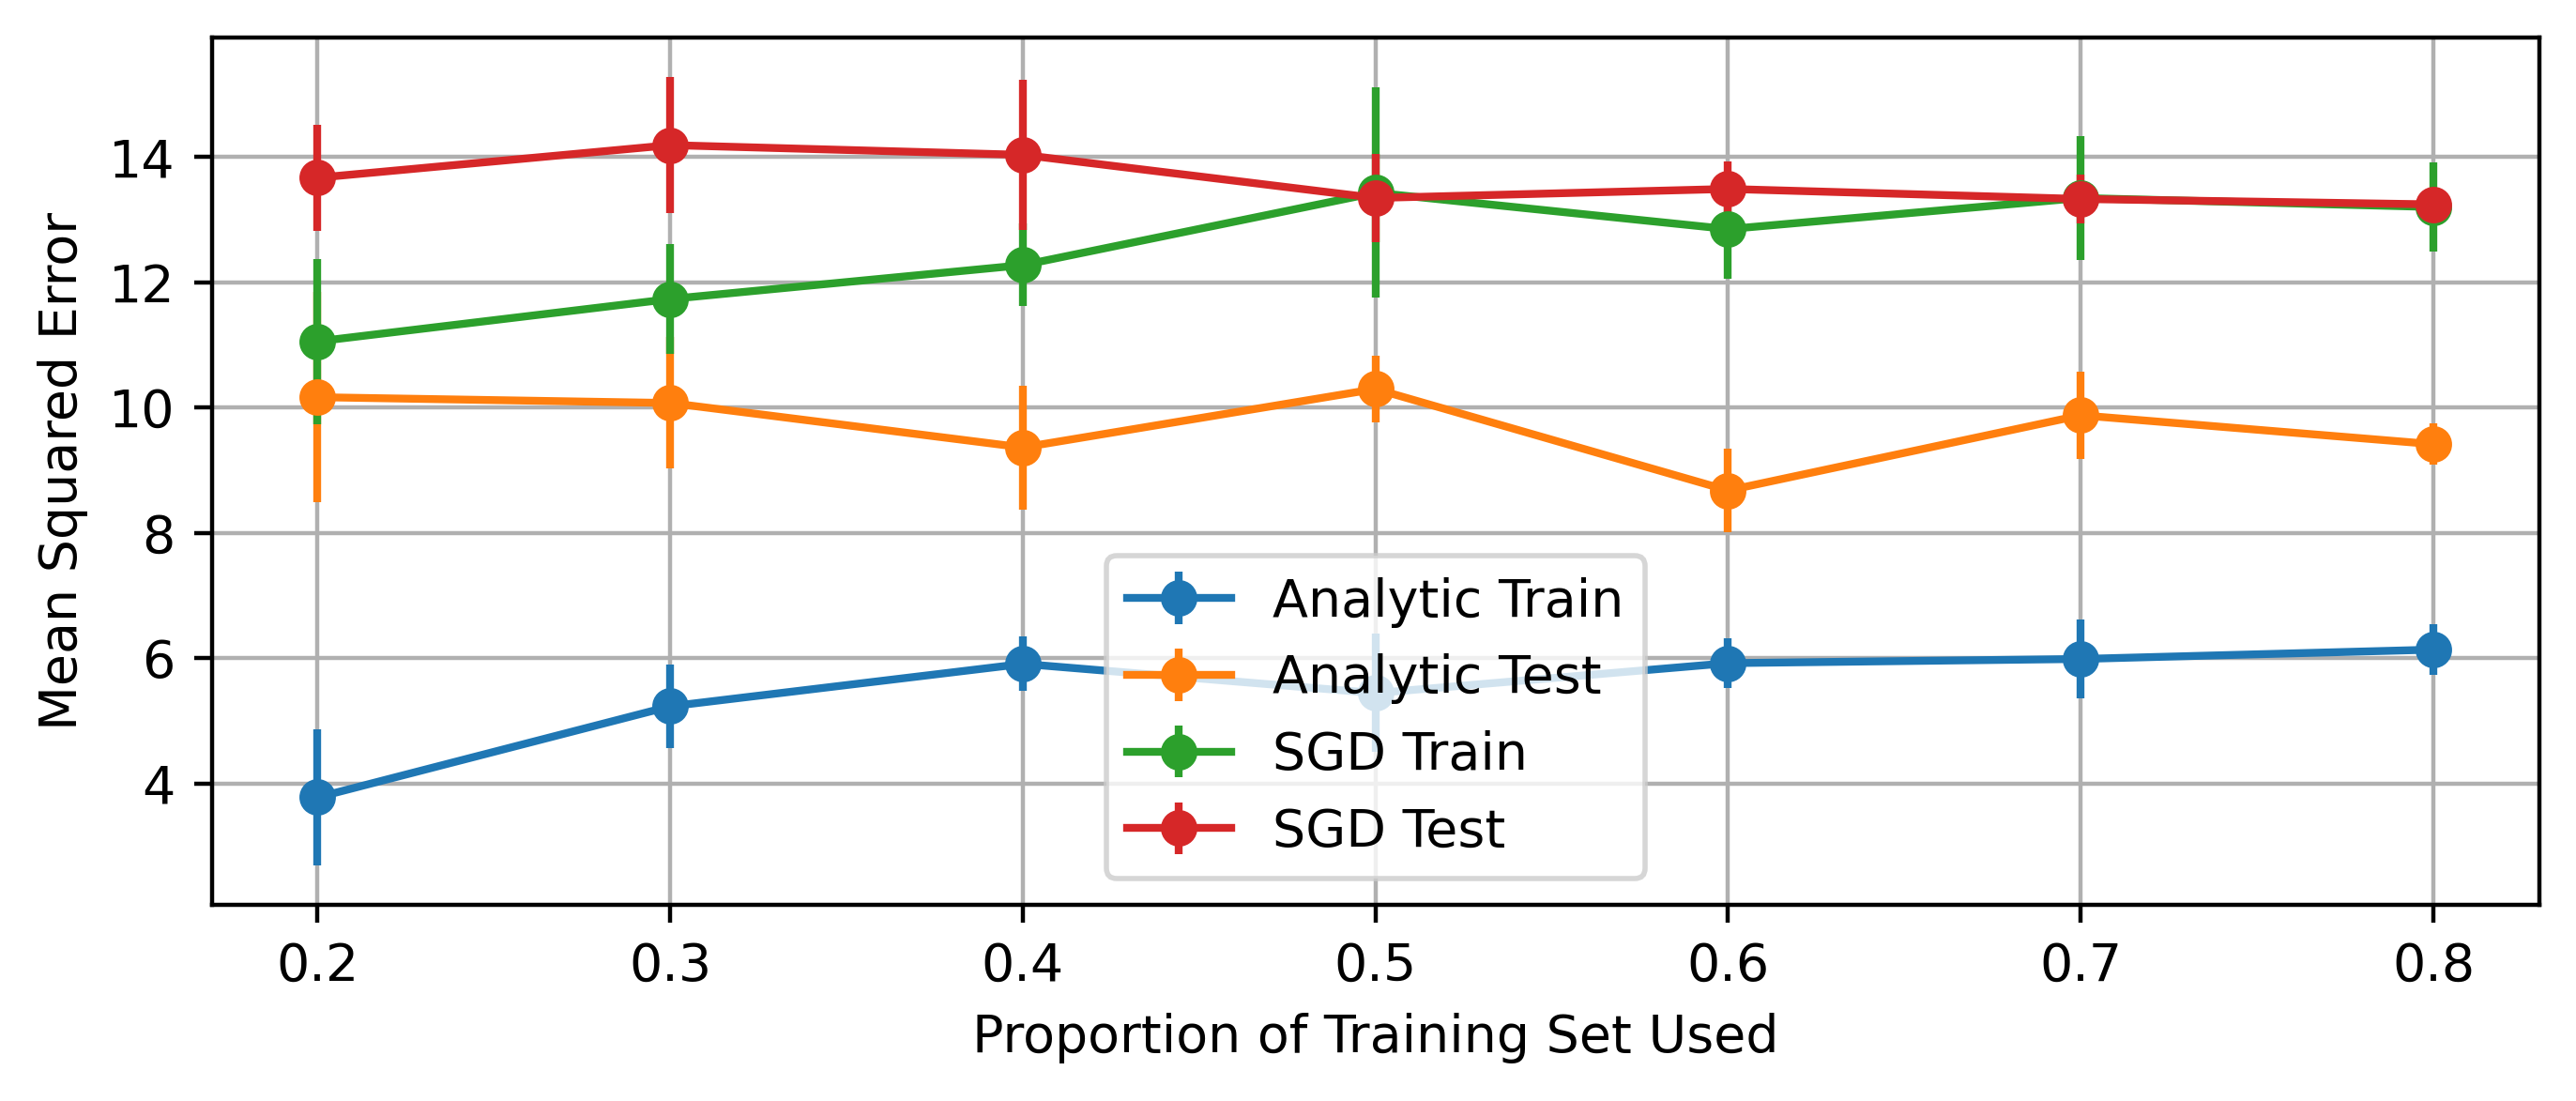

In [56]:
OPTIMIZER_KWARGS = {
    'batch_size': 32,
    'learning_rate': 0.1,
    'max_iters': 1e5,
    'verbose': False
}

# sizes to sample
sizes = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

num_trials = 5

analytic_train_errors = np.empty((len(sizes), num_trials))
analytic_test_errors = np.empty((len(sizes), num_trials))
sgd_train_errors = np.empty((len(sizes), num_trials))
sgd_test_errors = np.empty((len(sizes), num_trials))

ix_list = [i for i in range(X_housing_train.shape[0])]

for i, size in enumerate(sizes):
    # select data subset
    subset_size = int(size * X_housing_train.shape[0])

    for j in range(num_trials):
        subset = np.random.choice(ix_list, size=subset_size, replace=False)
        X_train_subset = X_housing_train[subset]
        y_train_subset = y_housing_train[subset]

        # analytic fit
        lin_reg = LinearRegression()
        lin_reg.fit(X_train_subset, y_train_subset, analytic_fit=True, verbose=False)
        y_preds_analytic_train = lin_reg.predict(X_train_subset)
        y_preds_analytic_test = lin_reg.predict(X_housing_test)
        analytic_train_errors[i][j] = mse(y_train_subset, y_preds_analytic_train)
        analytic_test_errors[i][j] = mse(y_housing_test, y_preds_analytic_test)

        # mini-batch SGD fit
        lin_reg.fit(X_train_subset, y_train_subset, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
        y_preds_sgd_train = lin_reg.predict(X_train_subset)
        y_preds_sgd_test = lin_reg.predict(X_housing_test)
        sgd_train_errors[i][j] = mse(y_train_subset, y_preds_sgd_train)
        sgd_test_errors[i][j] = mse(y_housing_test, y_preds_sgd_test)


cm1 = list([plt.cm.tab10(i) for i in range(len(sizes))])
plt.figure(figsize=(8,3))

plt.errorbar(sizes, analytic_train_errors.mean(axis=1), yerr=analytic_train_errors.std(axis=1), fmt='-o', label='Analytic Train', c=cm1[0])
plt.errorbar(sizes, analytic_test_errors.mean(axis=1), yerr=analytic_test_errors.std(axis=1), fmt='-o', label='Analytic Test', c=cm1[1])
plt.errorbar(sizes, sgd_train_errors.mean(axis=1), yerr=sgd_train_errors.std(axis=1), fmt='-o', label='SGD Train', c=cm1[2])
plt.errorbar(sizes, sgd_test_errors.mean(axis=1), yerr=sgd_test_errors.std(axis=1), fmt='-o', label='SGD Test', c=cm1[3])
plt.xlabel('Proportion of Training Set Used')
plt.ylabel('Mean Squared Error')
# plt.title('Effect of Training Data Size on MSE')
plt.grid(True)
plt.legend()


### Logistic Regression

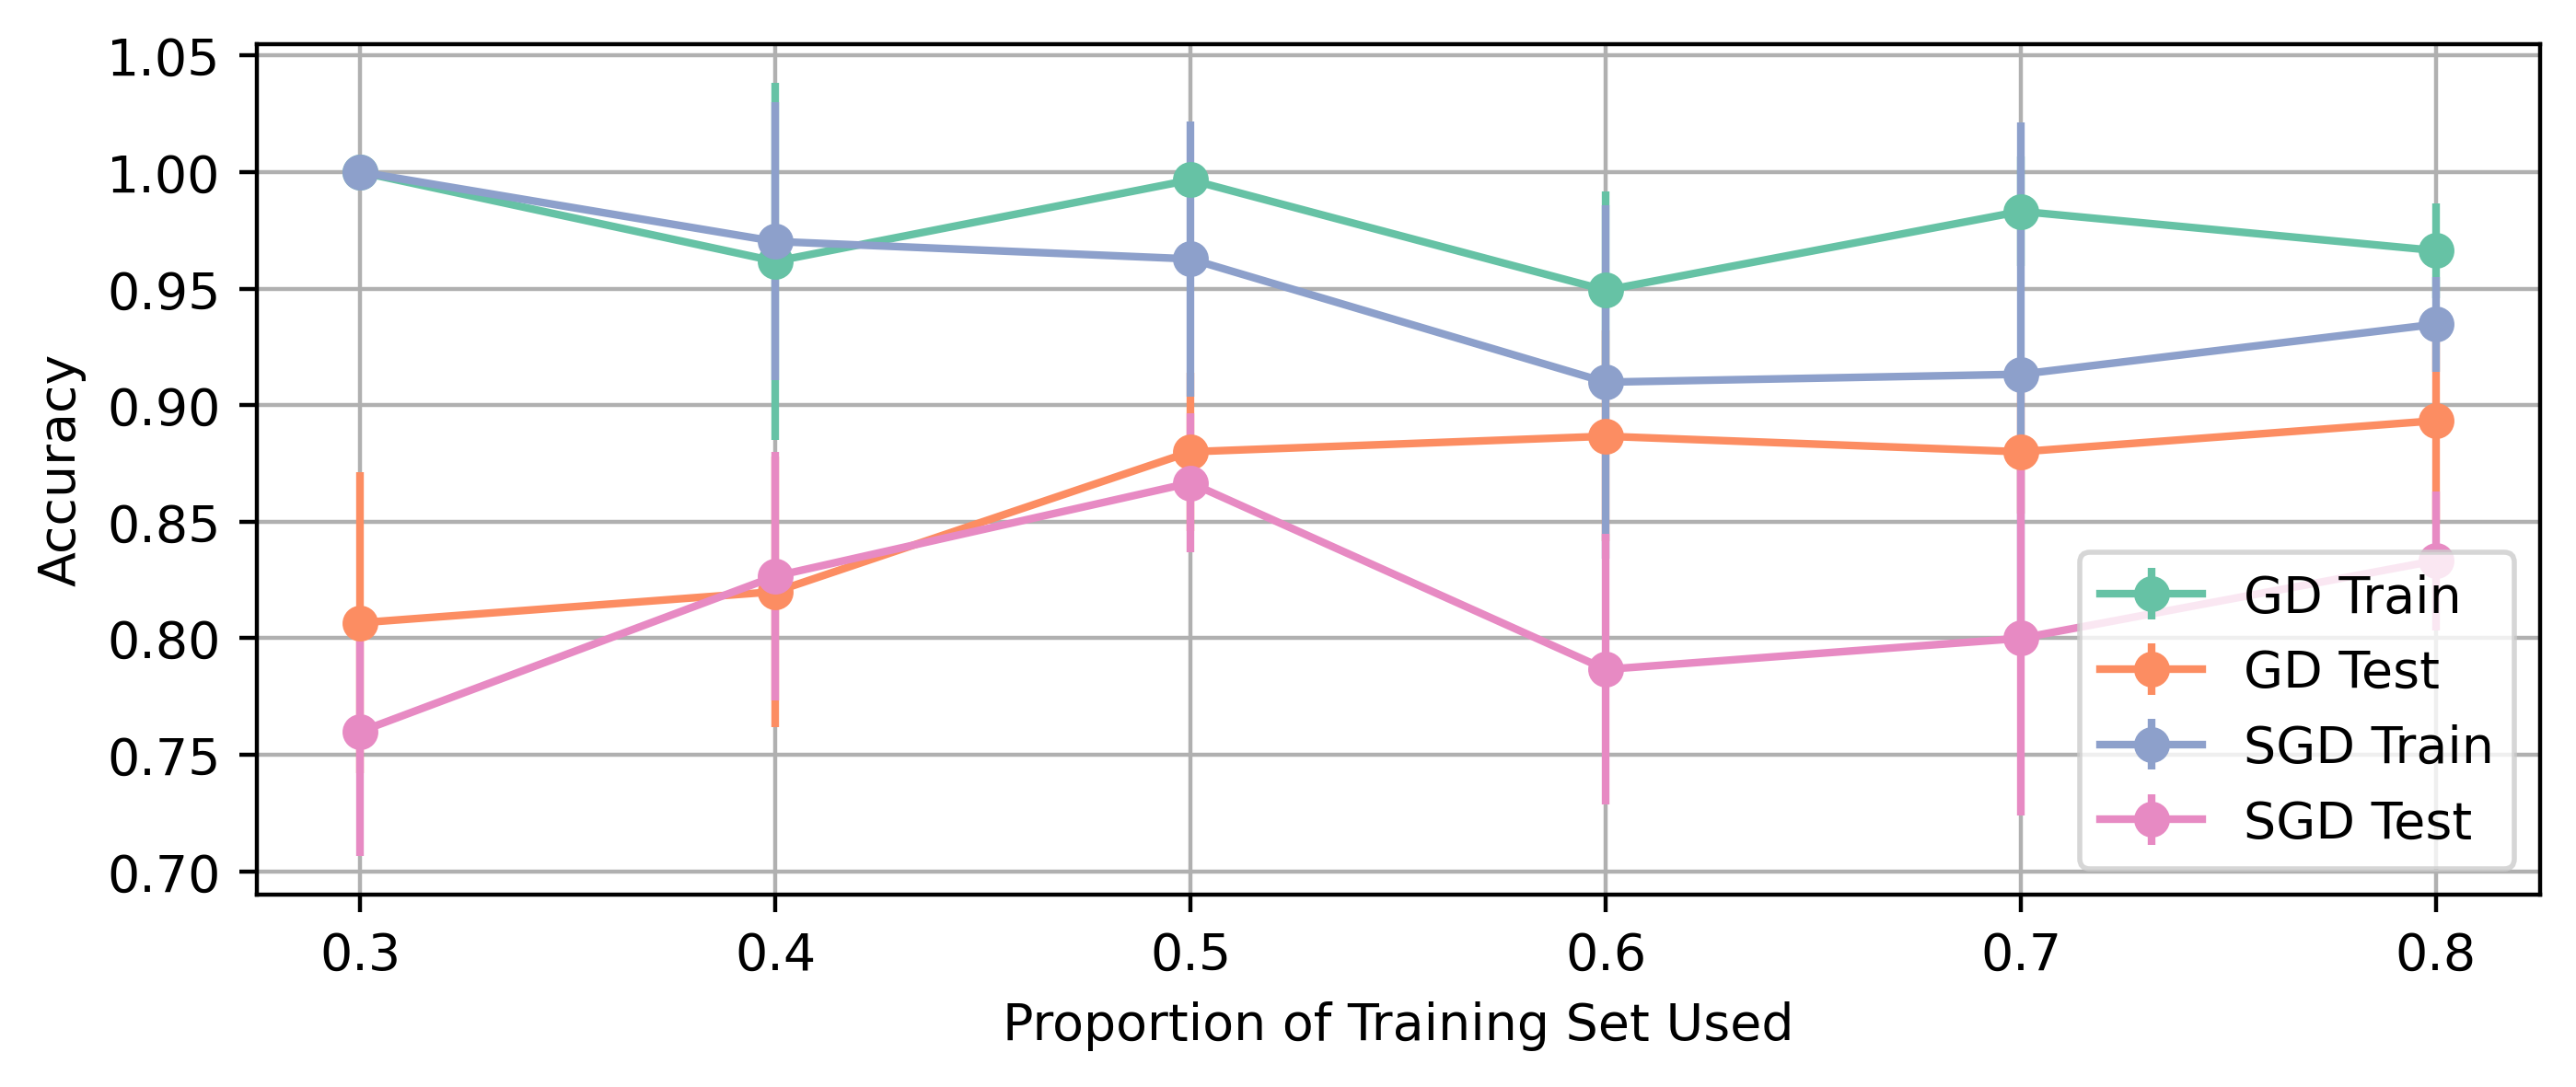

<Figure size 2560x1920 with 0 Axes>

In [57]:
BATCH_SIZE = 32
OPTIMIZER_KWARGS = {
    'max_iters': 1e5,
    'learning_rate': 0.1,
    'verbose': False
    }

# sizes to sample
sizes = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

num_trials = 5
gd_train_accuracies = np.empty((len(sizes), num_trials))
gd_test_accuracies = np.empty((len(sizes), num_trials))
sgd_train_accuracies = np.empty((len(sizes), num_trials))
sgd_test_accuracies = np.empty((len(sizes), num_trials))

ix_list = [i for i in range(X_wine_train.shape[0])]

for i, size in enumerate(sizes):
    # select data subset
    subset_size = int(size * X_wine_train.shape[0])

    for j in range(num_trials):
        subset = np.random.choice(ix_list, size=subset_size, replace=False)
        X_train_subset = X_wine_train[subset]
        y_train_subset = y_wine_train[subset]

        log_reg = LogisticRegression()
        
        # GD fit
        log_reg.fit(X_train_subset, y_train_subset, optimizer_class=GradientDescent, **OPTIMIZER_KWARGS)
        gd_train_accuracies[i][j] = accuracy_score(y_train_subset, log_reg.predict(X_train_subset))
        gd_test_accuracies[i][j] = accuracy_score(y_wine_test, log_reg.predict(X_wine_test))
        
        # mini-batch SGD fit
        log_reg.fit(X_train_subset, y_train_subset, optimizer_class=StochasticGradientDescent, batch_size=BATCH_SIZE, **OPTIMIZER_KWARGS)
        sgd_train_accuracies[i][j] = accuracy_score(y_train_subset, log_reg.predict(X_train_subset))
        sgd_test_accuracies[i][j] = accuracy_score(y_wine_test, log_reg.predict(X_wine_test))

cm2 = list([plt.cm.Set2(i) for i in range(len(sizes))])

plt.figure(figsize=(8, 3))
plt.errorbar(sizes, gd_train_accuracies.mean(axis=1), yerr=gd_train_accuracies.std(axis=1), fmt='-o', label="GD Train", c=cm2[0])
plt.errorbar(sizes, gd_test_accuracies.mean(axis=1), yerr=gd_test_accuracies.std(axis=1), fmt='-o', label="GD Test", c=cm2[1])
plt.errorbar(sizes, sgd_train_accuracies.mean(axis=1), yerr=sgd_train_accuracies.std(axis=1), fmt='-o', label="SGD Train", c=cm2[2])
plt.errorbar(sizes, sgd_test_accuracies.mean(axis=1), yerr=sgd_test_accuracies.std(axis=1), fmt='-o', label="SGD Test", c=cm2[3])
plt.xlabel("Proportion of Training Set Used")
plt.ylabel("Accuracy")
# plt.title("Effect of Training Data Size on Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Results

**Linear Regression**
- generalization performance increases with more data for analytical solution
- for SGD starting with 40%, performance is really stable independent of the amount of data

**Logistic Regression**
- performance peak already with only 40% of the data for training 
- logistic regression performance decreases afterwards
- linear regression stays on some sort of plateau, indicating that not more data is needed
- another time it helps for both

# Experiment 4: Minibatch Sizes
For both datasets, try out growing minibatch sizes, e.g., 8, 16, 32, 64, and 128. Compare the convergence speed and final performance of different batch sizes to the fully batched baseline. Which configuration works the best among the ones you tried?
Note: This is for SGD only (Task2, third main task).

### Data Preparation

In [4]:
TEST_SIZE = 0.2
IQR_FACTOR = 1.5

housing_df = HOUSING_DF.copy()
wine_df = WINE_DF.copy()

### Data Cleaning ###
# remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)

### Data Splitting ###
# perform train test split
one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(), 
                                                                        one_hot_wine_classes, test_size=TEST_SIZE, random_state=SEED)

X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), 
                                                                                    test_size=TEST_SIZE, random_state=SEED)

### Data Normalization ###
# normalize data after train test split to prevent data leakage
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test, scale=True)
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)

### Linear Regression

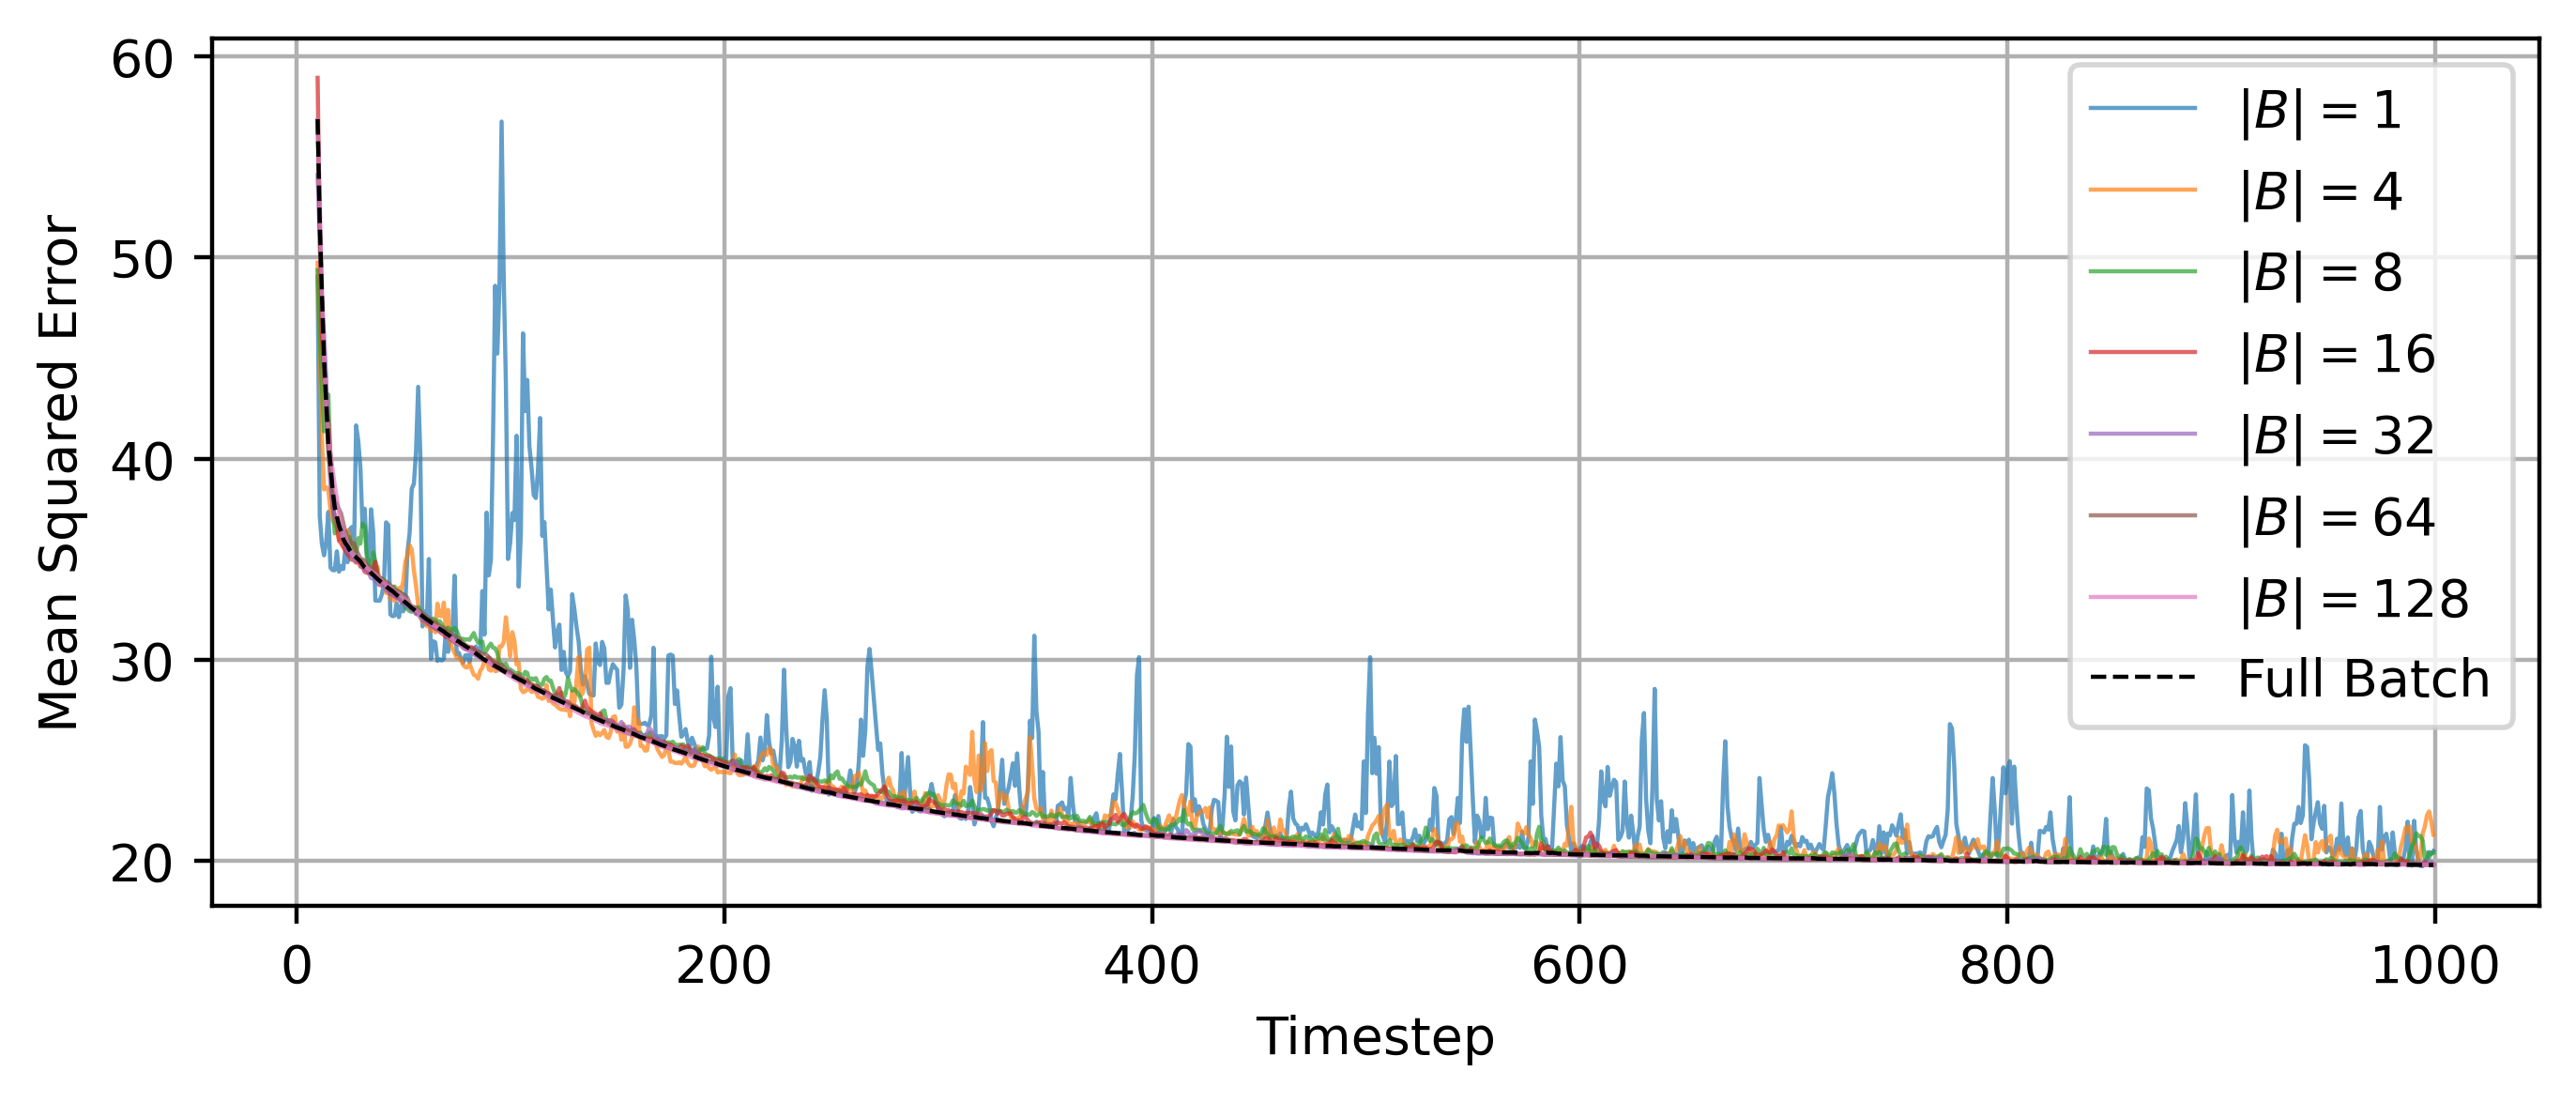

In [5]:
OPTIMIZER_KWARGS = {
    'learning_rate': 0.1,
    'max_iters': 1e5,
    'verbose': False,
    'record_history': True
}

batch_sizes = [1, 4, 8, 16, 32, 64, 128,  X_housing_train.shape[0]]

sgd_train_errors = []
sgd_test_errors = []
convergence_speeds = []

plotted_timesteps = 1_000
t_0 = 10 # start timestep to plot
t = [i for i in range(plotted_timesteps)]
sgd_train_errors_history = np.empty((len(batch_sizes), plotted_timesteps))

cm1 = list([plt.cm.tab10(i) for i in range(len(batch_sizes))])
plt.figure(figsize=(8,3))

for i, batch_size in enumerate(batch_sizes):
    lin_reg = LinearRegression()
    start_time = time.time()
    w_history = lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, batch_size=batch_size, **OPTIMIZER_KWARGS)
    end_time = time.time()

    y_preds_with_grad_train = lin_reg.predict(X_housing_train)
    y_preds_with_grad_test = lin_reg.predict(X_housing_test)
    sgd_train_errors.append(mse(y_housing_train, y_preds_with_grad_train))
    sgd_test_errors.append(mse(y_housing_test, y_preds_with_grad_test))
    convergence_speeds.append(end_time - start_time)

    # Plot performance vs. time
    for j in range(plotted_timesteps):
        sgd_train_errors_history[i][j] = mse(y_housing_train, lin_reg.predict(X_housing_train, w=w_history[j]))

    if batch_size == X_housing_train.shape[0]:
        label =  'Full Batch'
        plt.plot(t[t_0:], 
                 sgd_train_errors_history[i, t_0: ], 
                 linestyle='dashed', color='black', linewidth=0.8, label=label)
    else:
        label =  r'$|B|=' + str(batch_size) + r'$'
        plt.plot(t[t_0:], 
                 sgd_train_errors_history[i, t_0:], 
                 alpha=0.7, color=cm1[i], linewidth=0.8, label=label)


plt.xlabel("Timestep")
plt.ylabel("Mean Squared Error")
# plt.title("Effect of Training Data Size on Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# for batch_size, train_error, test_error, speed in zip(batch_sizes, sgd_train_errors, sgd_test_errors, convergence_speeds):
#     print(f"Batch Size: {batch_size}, Train Error: {train_error:.5g}, Test Error: {test_error:.5g}, Convergence Speed: {speed:.3g} seconds")

### Logistic Regression

0.25
0.25
0.25
0.25
0.25
0.25
0.25


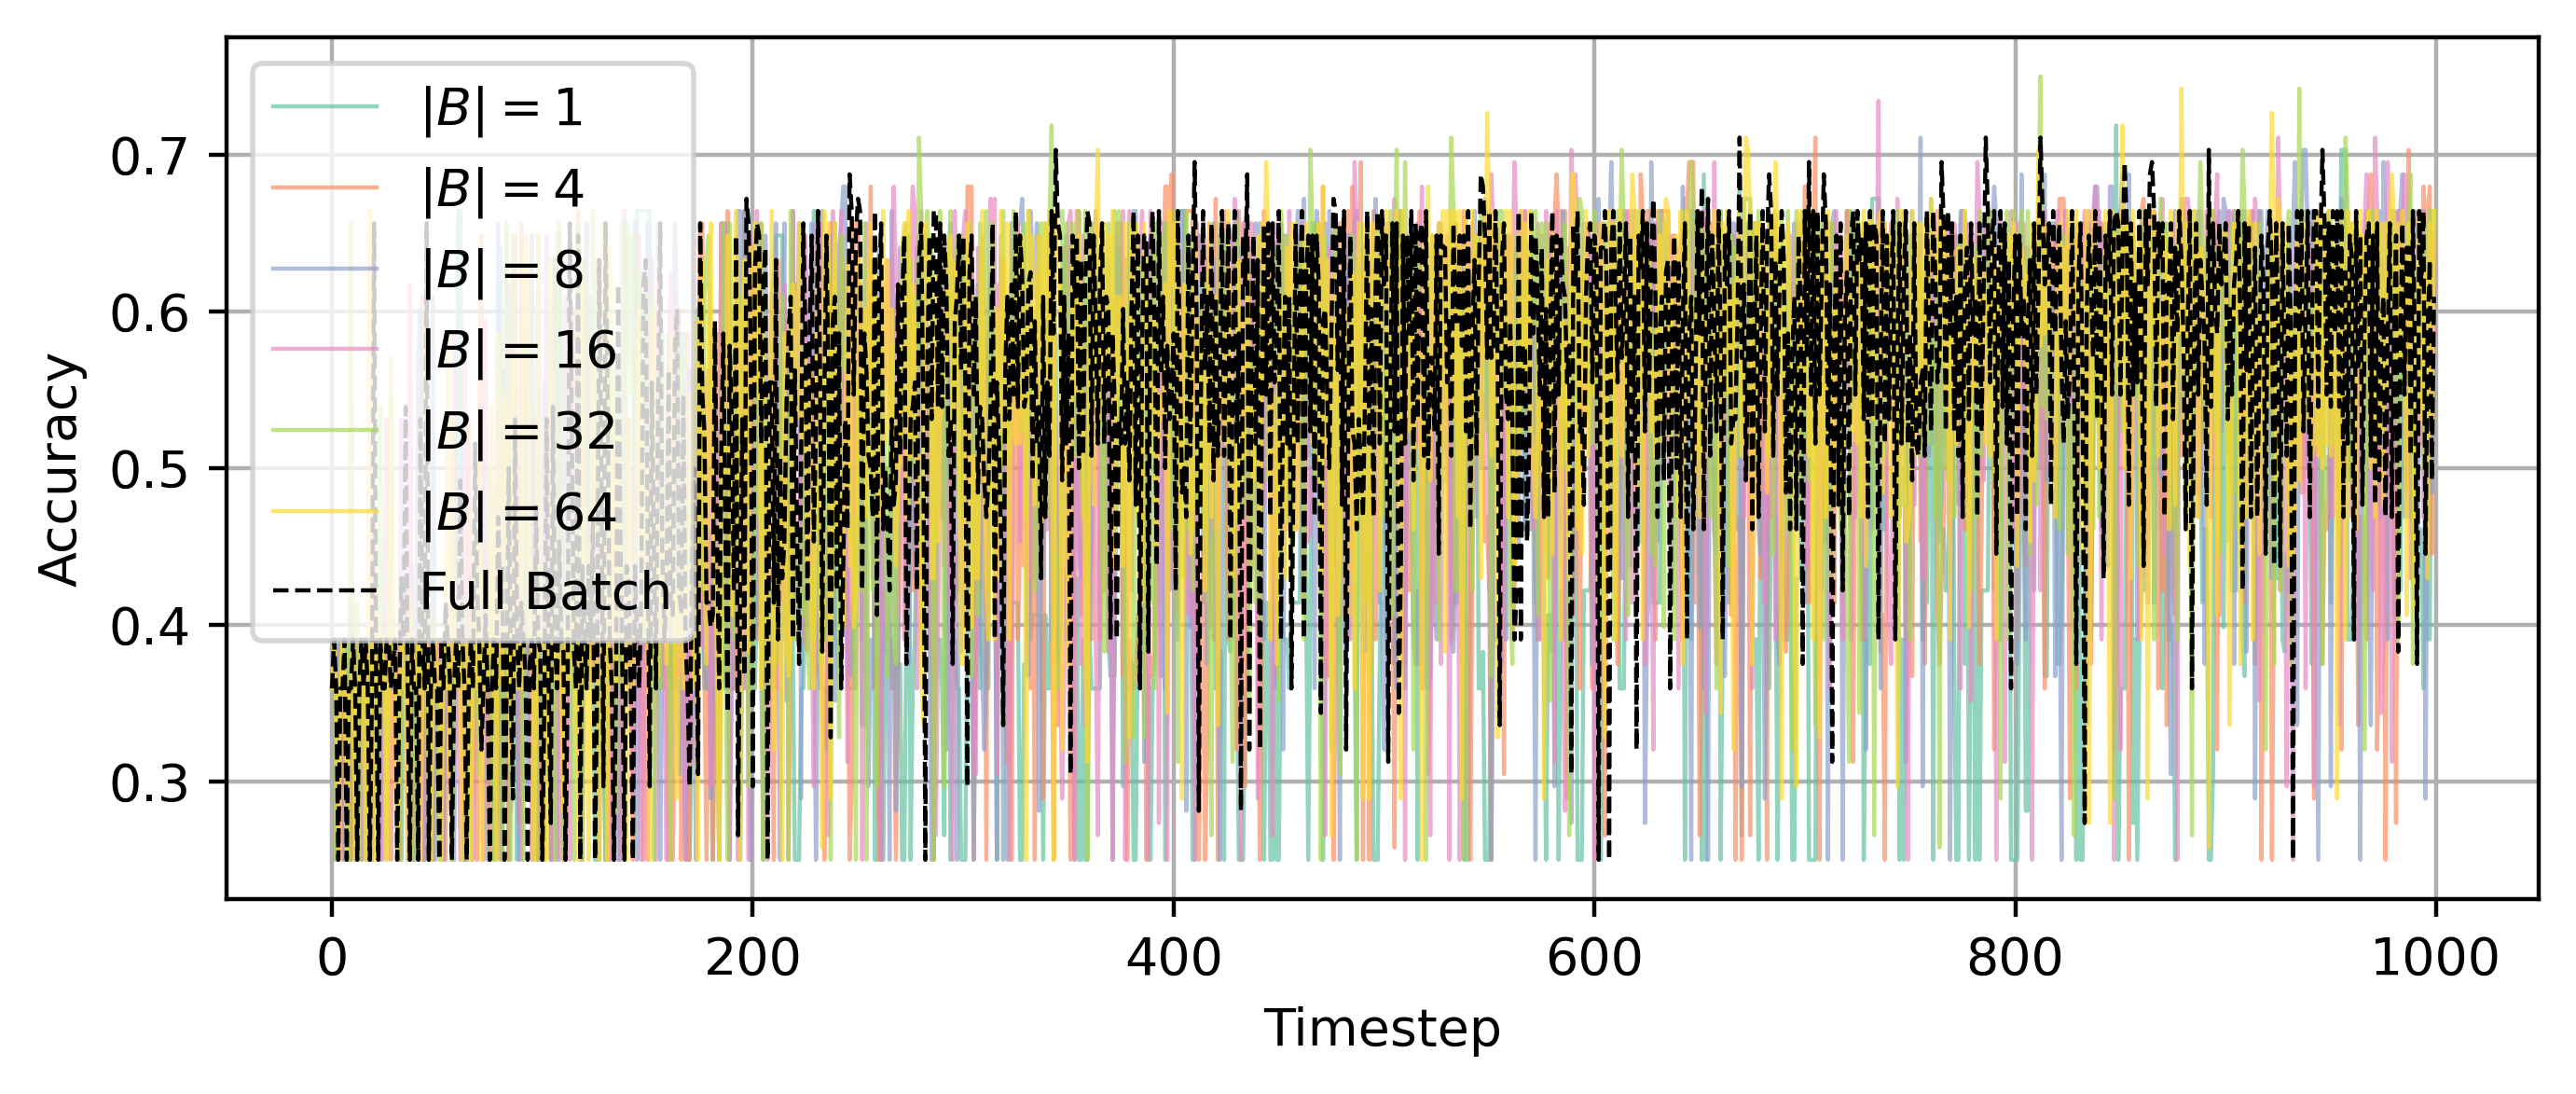

Batch Size & Train Accuracy & Test Accuracy & Convergence Time (s)
1 & 0.64844 & 0.636364 & 0.0997
4 & 0.64844 & 0.666667 & 0.0716
8 & 0.57031 & 0.606061 & 0.0978
16 & 0.58594 & 0.636364 & 0.0904
32 & 0.66406 & 0.666667 & 0.0994
64 & 0.66406 & 0.69697 & 0.102
128 & 0.60938 & 0.666667 & 0.113


In [7]:
OPTIMIZER_KWARGS = {
    'max_iters': 1e5,
    'learning_rate': 0.1,
    'verbose': False,
    'record_history': True
    }

batch_sizes = [1, 4, 8, 16, 32, 64, X_wine_train.shape[0]]  


sgd_train_accuracies = []
sgd_test_accuracies = []
convergence_speeds = []

plotted_timesteps = 1_000
t_0 = 0 # start timestep to plot
t = [i for i in range(plotted_timesteps)]
sgd_train_accuracies_history = np.empty((len(batch_sizes), plotted_timesteps))

cm2 = list([plt.cm.Set2(i) for i in range(len(batch_sizes))])
plt.figure(figsize=(8,3))


for i, batch_size in enumerate(batch_sizes):
    log_reg = LogisticRegression()
    
    # mini-batch SGD fit
    start_time = time.time()
    w_history = log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, batch_size=batch_size, **OPTIMIZER_KWARGS)
    end_time = time.time()
    
    sgd_train_accuracies.append(accuracy_score(y_wine_train, log_reg.predict(X_wine_train)))
    sgd_test_accuracies.append(accuracy_score(y_wine_test, log_reg.predict(X_wine_test)))
    convergence_speeds.append(end_time - start_time)

    # Plot performance vs. time
    for j in range(plotted_timesteps):
        sgd_train_accuracies_history[i][j] = accuracy_score(y_wine_train, log_reg.predict(X_wine_train, w=w_history[j]))

    if batch_size == X_wine_train.shape[0]:
        label =  'Full Batch'
        plt.plot(t[t_0:], 
                 sgd_train_accuracies_history[i, t_0: ], 
                 linestyle='dashed', color='black', linewidth=0.8, label=label)
    else:
        label =  r'$|B|=' + str(batch_size) + r'$'
        plt.plot(t[t_0:], 
                 sgd_train_accuracies_history[i, t_0:], 
                 alpha=0.7, color=cm2[i], linewidth=0.8, label=label)
        
plt.xlabel("Timestep")
plt.ylabel("Accuracy")

# plt.title("Effect of Training Data Size on Accuracy")
plt.legend()
plt.grid(True)
plt.show()

print('Batch Size & Train Accuracy & Test Accuracy & Convergence Time (s)')
# for batch_size, train_acc, test_acc, speed in zip(batch_sizes, sgd_train_accuracies, sgd_test_accuracies, convergence_speeds):
#     print(f"Batch size {batch_size}: Train Acc: {train_acc:.5g}, Test Acc: {test_acc:5g}, Convergence Time: {speed:.3g} seconds")
for batch_size, train_acc, test_acc, speed in zip(batch_sizes, sgd_train_accuracies, sgd_test_accuracies, convergence_speeds):
    print(f"{batch_size} & {train_acc:.5g} & {test_acc:5g} & {speed:.3g}")

### Results

**Linear Regression**
- does not really matter

**Logistic Regression**
- best performance with Gradient Descent (whole data set as batch)
- converence fastest with batch size 16, but all very close

## Experiment 4+: Adding Momentum

### Linear Regression

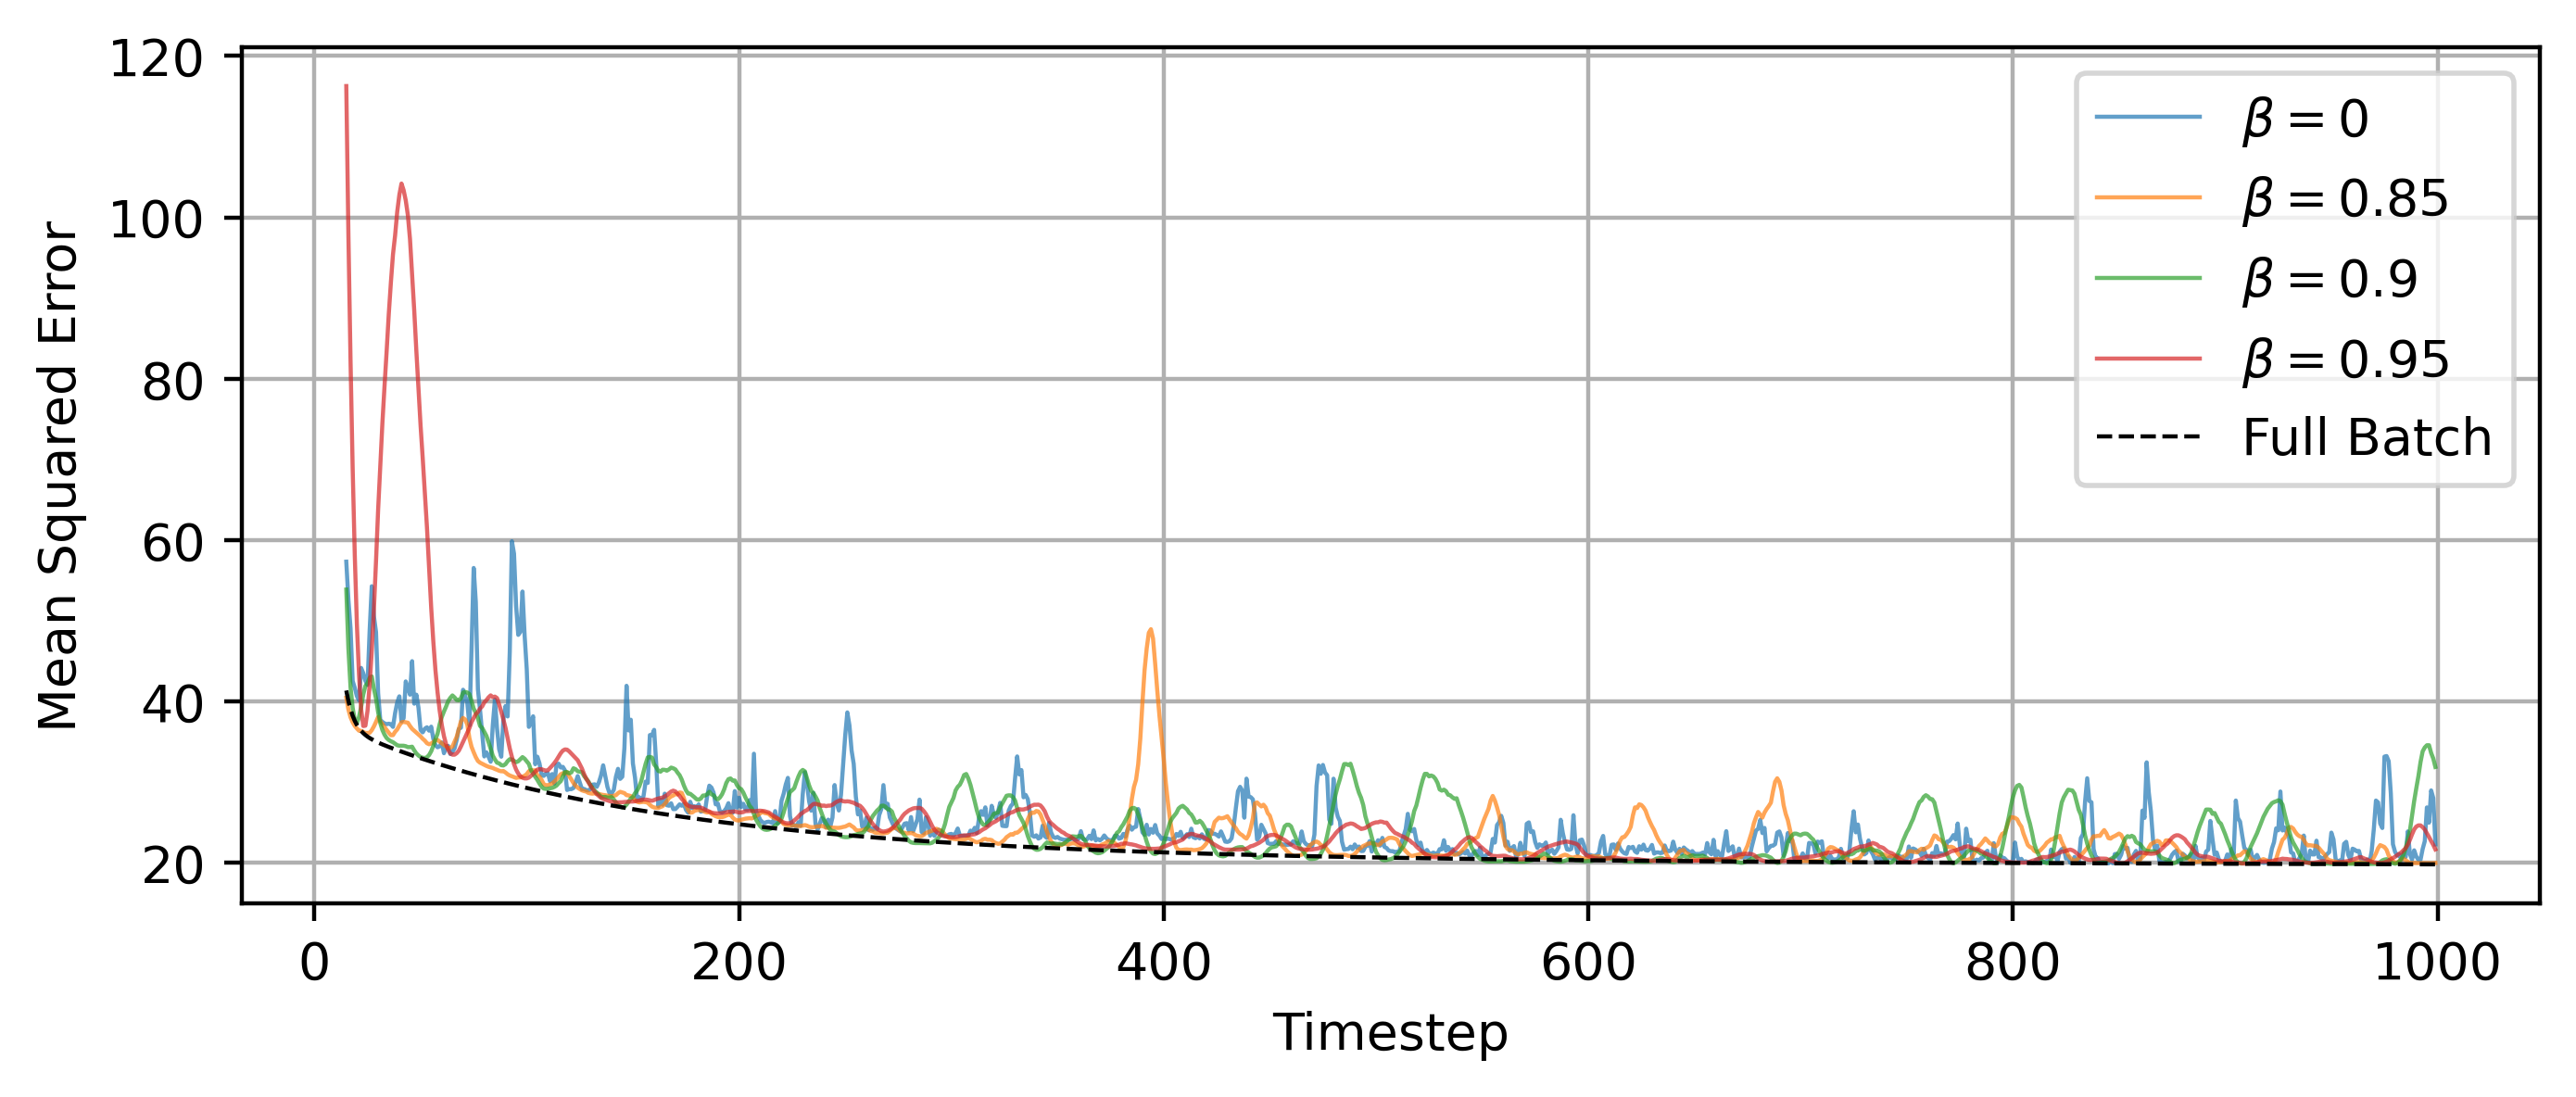

In [11]:
OPTIMIZER_KWARGS = {
    'learning_rate': 0.1,
    'max_iters': 1e5,
    'verbose': False,
    'record_history': True
}

betas = [0, 0.85, 0.9, 0.95, -1]    # momentum parameters

plotted_timesteps = 1_000
t_0 = 15 # start timestep to plot
t = [i for i in range(plotted_timesteps)]
sgd_train_errors_history = np.empty((len(betas), plotted_timesteps))

cm1 = list([plt.cm.tab10(i) for i in range(len(batch_sizes))])
plt.figure(figsize=(8,3))

for i, beta in enumerate(betas):
    lin_reg = LinearRegression()

    if beta == -1:  # Compare to Full batch baseline
        w_history = lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=GradientDescent, **OPTIMIZER_KWARGS)
    else:
        w_history = lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, beta=beta, batch_size=1, **OPTIMIZER_KWARGS)

    # Plot performance vs. time
    for j in range(plotted_timesteps):
        sgd_train_errors_history[i][j] = mse(y_housing_train, lin_reg.predict(X_housing_train, w=w_history[j]))

    if beta == -1:
        label =  'Full Batch'
        plt.plot(t[t_0:], 
                 sgd_train_errors_history[i, t_0: ], 
                 linestyle='dashed', color='black', linewidth=0.8, label=label)
    else:
        label =  r'$\beta=' + str(beta) + r'$'
        plt.plot(t[t_0:], 
                 sgd_train_errors_history[i, t_0:], 
                 alpha=0.7, color=cm1[i], linewidth=0.8, label=label)


plt.xlabel("Timestep")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.show()


### Logistic Regression

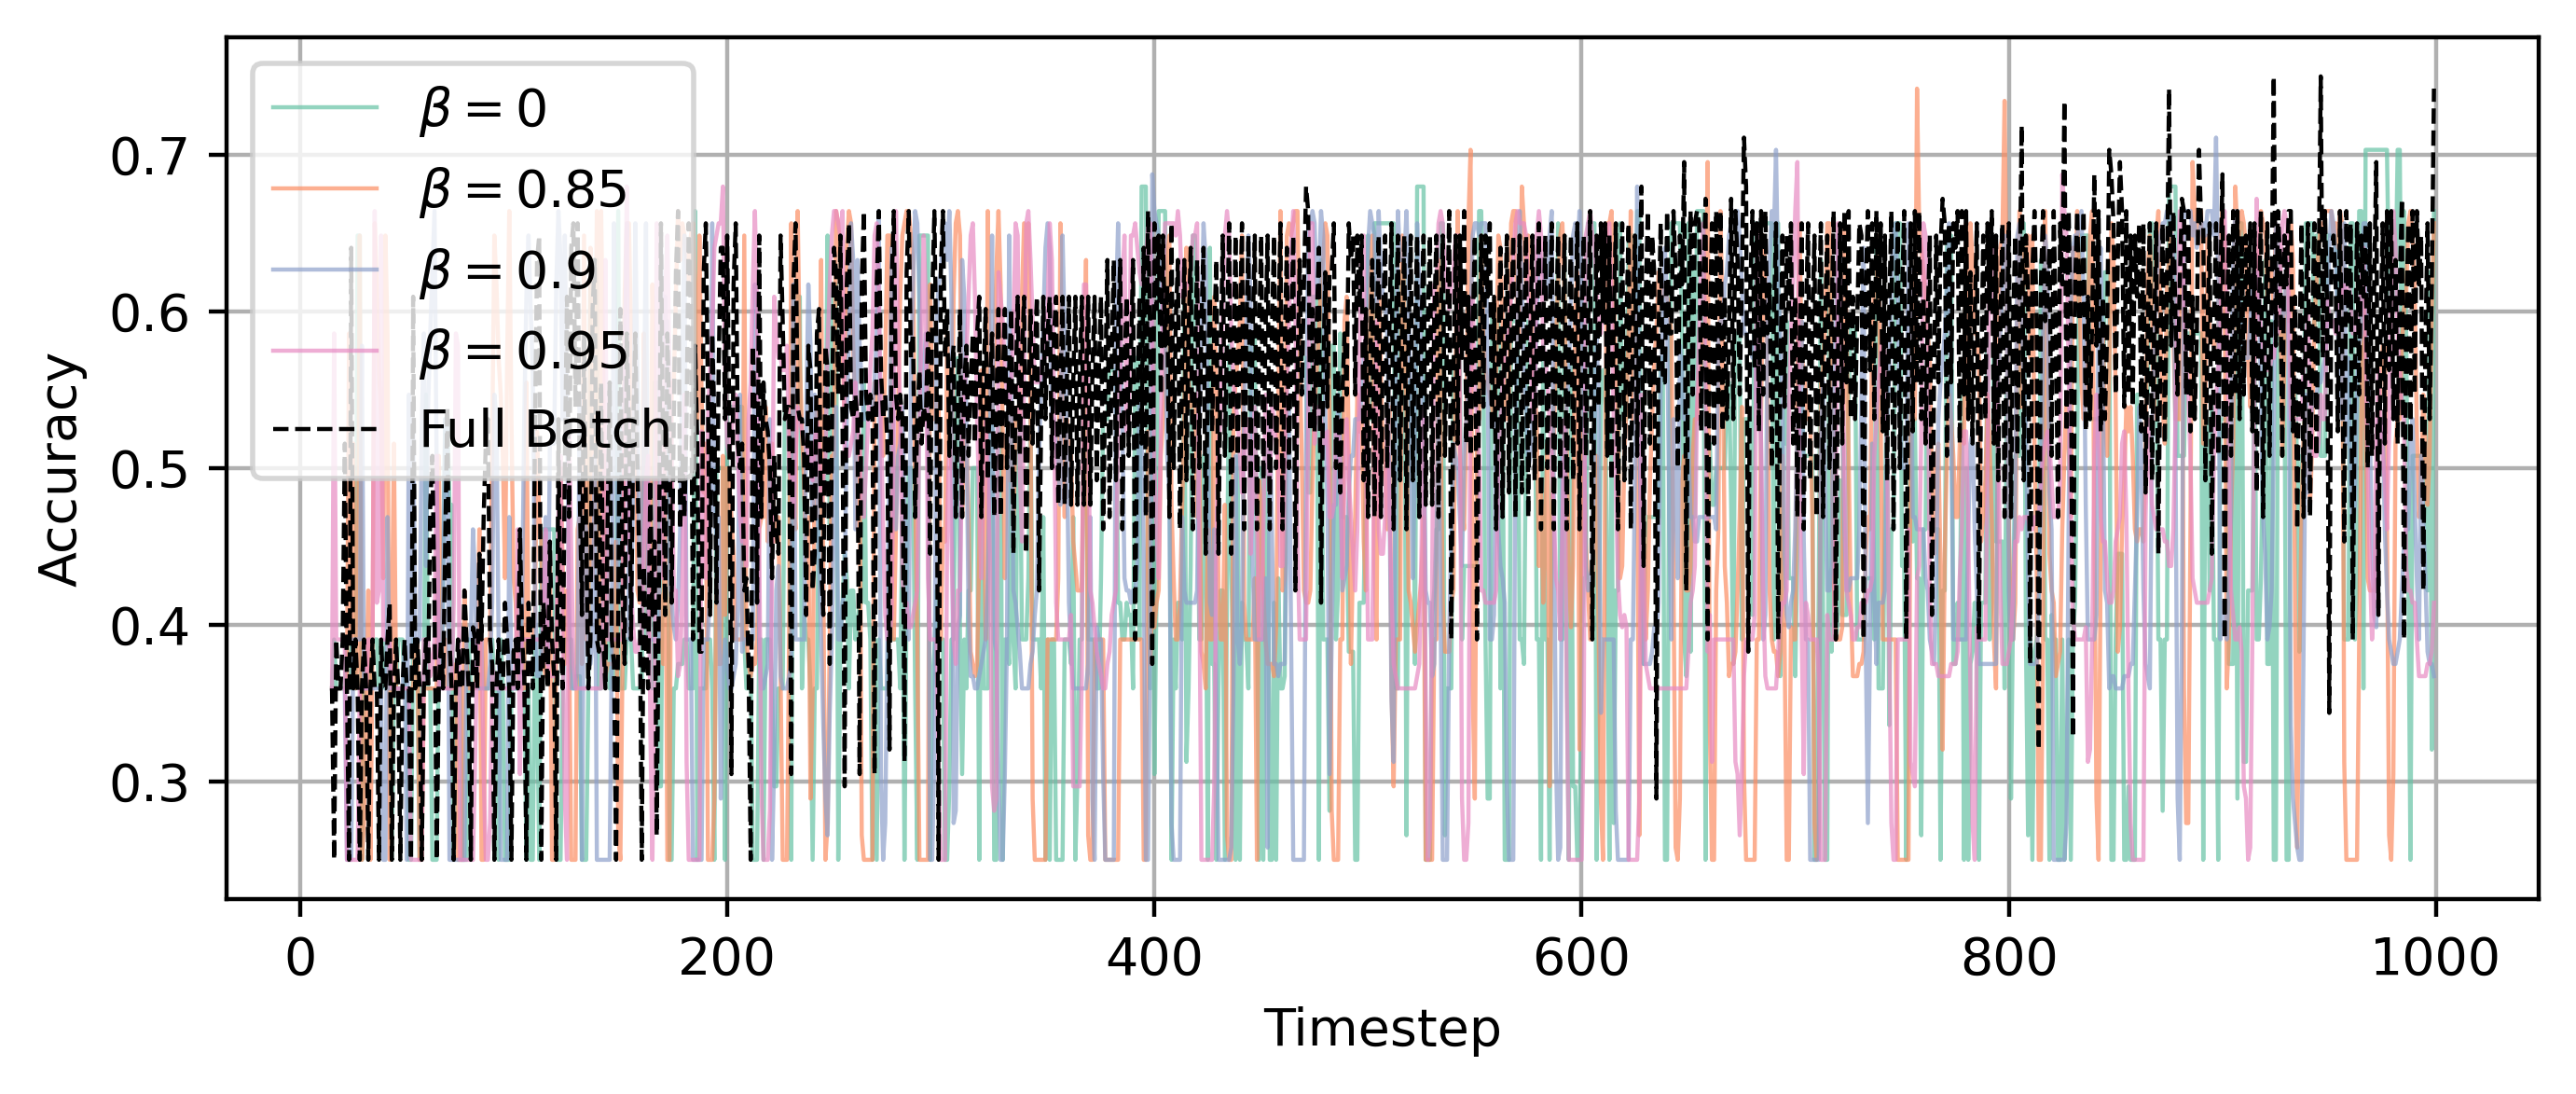

In [13]:
OPTIMIZER_KWARGS = {
    'learning_rate': 0.1,
    'max_iters': 1e5,
    'verbose': False,
    'record_history': True
}

betas = [0, 0.85, 0.9, 0.95, -1]    # momentum parameters

plotted_timesteps = 1_000
t_0 = 15 # start timestep to plot
t = [i for i in range(plotted_timesteps)]
sgd_train_accuracies_history = np.empty((len(betas), plotted_timesteps))

cm2 = list([plt.cm.Set2(i) for i in range(len(batch_sizes))])
plt.figure(figsize=(8,3))

for i, beta in enumerate(betas):
    log_reg = LogisticRegression()

    if beta == -1:  # Compare to Full batch baseline
        w_history = log_reg.fit(X_wine_train, y_wine_train, optimizer_class=GradientDescent, **OPTIMIZER_KWARGS)
    else:
        w_history = log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, beta=beta, batch_size=1, **OPTIMIZER_KWARGS)

    # Plot performance vs. time
    for j in range(plotted_timesteps):
        sgd_train_accuracies_history[i][j] = accuracy_score(y_wine_train, log_reg.predict(X_wine_train, w=w_history[j]))

    if beta == -1:
        label =  'Full Batch'
        plt.plot(t[t_0:], 
                 sgd_train_accuracies_history[i, t_0: ], 
                 linestyle='dashed', color='black', linewidth=0.8, label=label)
    else:
        label =  r'$\beta=' + str(beta) + r'$'
        plt.plot(t[t_0:], 
                 sgd_train_accuracies_history[i, t_0:], 
                 alpha=0.7, color=cm2[i], linewidth=0.8, label=label)


plt.xlabel("Timestep")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# Experiment 5: Different Learning Rates
For both datasets, Present the performance of both linear and logistic regression with at least three different learning rates (your own choice).

### Data Preparation

In [15]:
TEST_SIZE = 0.2
IQR_FACTOR = 1.5

housing_df = HOUSING_DF.copy()
wine_df = WINE_DF.copy()

### Data Cleaning ###
#remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)

### Data Splitting ###
# perform train test split
X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), 
                                                                                    test_size=TEST_SIZE, random_state=SEED)

one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(),
                                                                        one_hot_wine_classes, test_size=TEST_SIZE, random_state=SEED)


### Data Normalization ###
# normalize data after train test split to prevent data leakage
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test)

### Linear Regression

Learning Rate: 0.005, Train Error: 20.670, Test Error: 16.819
Learning Rate: 0.01, Train Error: 19.792, Test Error: 16.852
Learning Rate: 0.05, Train Error: 18.234, Test Error: 15.039
Learning Rate: 0.1, Train Error: 17.413, Test Error: 13.837
Learning Rate: 0.2, Train Error: 16.754, Test Error: 12.398
Learning Rate: 0.5, Train Error: 16.013, Test Error: 12.459
Learning Rate: 0.7, Train Error: 15.149, Test Error: 10.298
Learning Rate: 1.0, Train Error: 15.099, Test Error: 11.482


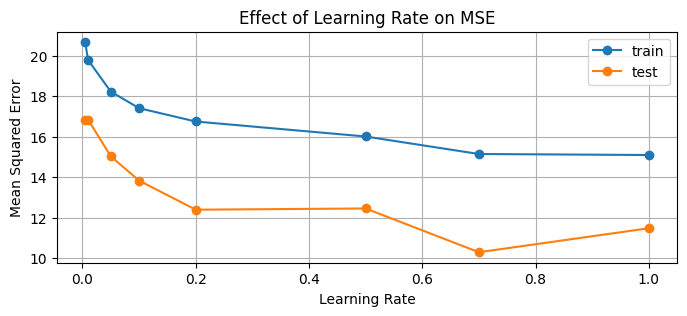

In [16]:
OPTIMIZER_KWARGS = {
    'batch_size': 32,
    'max_iters': 1e4,
    'verbose': False
}
LEARNING_RATES = [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1.0]

train_errors = []
test_errors = []

for lr in LEARNING_RATES:
    lin_reg = LinearRegression()

    lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, learning_rate=lr, **OPTIMIZER_KWARGS)
    
    y_preds_train = lin_reg.predict(X_housing_train)
    y_preds_test = lin_reg.predict(X_housing_test)
    train_errors.append(mse(y_housing_train, y_preds_train))
    test_errors.append(mse(y_housing_test, y_preds_test))

    print(f"Learning Rate: {lr}, Train Error: {train_errors[-1]:.3f}, Test Error: {test_errors[-1]:.3f}")

# plot results of different learning rates
plt.figure(figsize=(8,3))
plt.plot(LEARNING_RATES, train_errors, '-o',label='train')
plt.plot(LEARNING_RATES, test_errors, '-o',label='test')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Effect of Learning Rate on MSE')
plt.grid(True)
plt.show()


### Logistic Regression

Learning Rate: 0.005, Train Accuracy: 0.891, Test Accuracy: 0.909
Learning Rate: 0.01, Train Accuracy: 0.555, Test Accuracy: 0.697
Learning Rate: 0.05, Train Accuracy: 0.875, Test Accuracy: 0.909
Learning Rate: 0.1, Train Accuracy: 0.930, Test Accuracy: 1.000
Learning Rate: 0.2, Train Accuracy: 0.930, Test Accuracy: 0.970
Learning Rate: 0.5, Train Accuracy: 0.766, Test Accuracy: 0.727
Learning Rate: 0.7, Train Accuracy: 0.781, Test Accuracy: 0.727
Learning Rate: 1.0, Train Accuracy: 0.945, Test Accuracy: 0.939


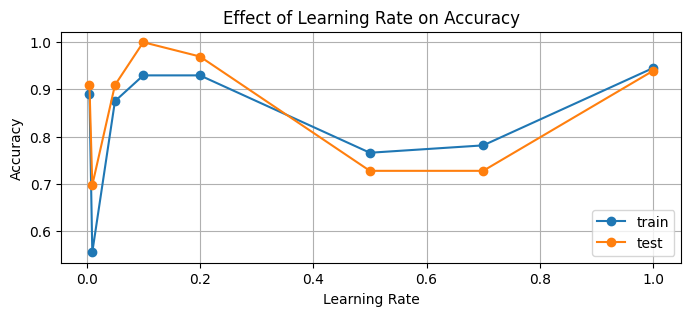

In [17]:
OPTIMIZER_KWARGS = {
    'batch_size': 16,
    'max_iters': 4e4,
    'verbose': False
    }
LEARNING_RATES = [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1.0]

train_accuracies = []
test_accuracies = []

for lr in LEARNING_RATES:
    log_reg = LogisticRegression()

    log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, learning_rate=lr, **OPTIMIZER_KWARGS)
    
    y_preds_train = log_reg.predict(X_wine_train)
    y_preds_test = log_reg.predict(X_wine_test)
    train_accuracies.append(accuracy_score(y_wine_train, y_preds_train))
    test_accuracies.append(accuracy_score(y_wine_test, y_preds_test))

    print(f"Learning Rate: {lr}, Train Accuracy: {train_accuracies[-1]:.3f}, Test Accuracy: {test_accuracies[-1]:.3f}")

# plot results of different learning rates
plt.figure(figsize=(8,3))
plt.plot(LEARNING_RATES, train_accuracies, '-o',label='train')
plt.plot(LEARNING_RATES, test_accuracies, '-o',label='test')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Effect of Learning Rate on Accuracy')
plt.grid(True)
plt.show()

### Results

**Linear Regression**
- the higher the learning rate, the lower the error
- goes up again a bit after 0.7
- best performance with learning rate 0.7

**Logistic Regression**
- much more unstable, no clear trend
- best performance with learning rate 0.2

# Experiment 6: Different Parameter Configurations
For both datasets, Given a variety of parameter configurations, select a performance metric and present the optimal parameter choice for each dataset. Please provide a rationale for your metric selection, along with an explanation of why you opted for that particular metric

### Linear Regression

In [ ]:
PARAM_GRID = {
    'IQR_FACTOR': [1.0, 1.5, 2.0],
    'BATCH_SIZE': [1, 8, 16, 32, 64],
    'LEARNING_RATE': [0.05, 0.1, 0.5, 0.7],
    'MAX_ITERS': [1e4, 1e5],
    'MOMENTUM': [0.0, 0.5, 0.9]
}
TEST_SIZE = 0.2

print(f"Number of combinations: {len(list(product(*PARAM_GRID.values())))}")

housing_df = HOUSING_DF.copy()

count = 1
housing_param_search_results = []

for params in product(*PARAM_GRID.values()):
    IQR_FACTOR = params[0]
    OPTIMIZER_KWARGS = {
        'batch_size': params[1],
        'learning_rate': params[2],
        'max_iters': params[3],
        'beta': params[4],
        'verbose': False
    }

    ### Data Cleaning ###
    temp_df = housing_df.drop(columns='CHAS')
    temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
    housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

    ### Data Splitting ###
    # split into train and test sets
    X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                        housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), 
                                                                                        test_size=TEST_SIZE, random_state=SEED)

    for X_train_fold, y_train_fold, X_test_fold, y_test_fold in k_fold_split(X_housing_train, y_housing_train, n_splits=3):

        mse_train = []
        mse_val = []

        ### Data Normalization ###
        X_train_fold, X_test_fold = min_max_scale(X_train_fold, X_test_fold)

        lin_reg = LinearRegression()

        start_time = time.time()
        lin_reg.fit(X_train_fold, y_train_fold, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
        end_time = time.time()

        y_preds_sgd_train = lin_reg.predict(X_train_fold)
        y_preds_sgd_val = lin_reg.predict(X_test_fold)
        mse_train.append(mse(y_train_fold, y_preds_sgd_train))
        mse_val.append(mse(y_test_fold, y_preds_sgd_val))

    # data normalization
    X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)

    lin_reg = LinearRegression()
    lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
    mse_test = mse(y_housing_test, lin_reg.predict(X_housing_test))

    # save results
    param_dict = dict(zip(PARAM_GRID.keys(), params))
    result_dict = {
        'IQR Factor': param_dict['IQR_FACTOR'],
        'Batch Size': param_dict['BATCH_SIZE'],
        'Learning Rate': param_dict['LEARNING_RATE'],
        'Max Iters': param_dict['MAX_ITERS'],
        'Momentum': param_dict['MOMENTUM'],
        'Mean Train MSE': np.mean(mse_train).round(3),
        'Mean Validation MSE': np.mean(mse_val).round(3),
        'Test MSE': mse_test.round(3),
        'Convergence Speed': np.round((end_time - start_time), 4)
    }
    housing_param_search_results.append(result_dict)

    print(f"{count}: Params: {params}, Mean Val MSE: {np.mean(mse_val).round(3)}, Test MSE: {mse_test.round(3)}, Speed: {np.round((end_time - start_time), 2)}s")
    count += 1

Number of combinations: 360


1: Params: (1.0, 1, 0.05, 10000.0, 0.0), Mean Val MSE: 13.918, Test MSE: 12.451, Speed: 0.79s
2: Params: (1.0, 1, 0.05, 10000.0, 0.5), Mean Val MSE: 13.072, Test MSE: 12.307, Speed: 0.86s


KeyboardInterrupt: 

In [ ]:
# TODO plot results for different parameters
housing_param_search_results_df = pd.DataFrame(housing_param_search_results)

# save results
housing_param_search_results_df.to_csv('results/6/param_search_housing.csv', index=False)

In [ ]:
# load dataframe
housing_param_search_results_df = pd.read_csv('results/6/param_search_housing.csv')

# plot top 10 rows with highest validation mse
housing_param_search_results_df.sort_values(by='Mean Validation MSE', ascending=True).head(20)

IQR Factor  Batch Size  Learning Rate  Max Iters  Momentum  \
40          1.0           8            0.5   100000.0       0.5   
46          1.0           8            0.7   100000.0       0.5   
119         1.0          64            0.7   100000.0       0.9   
69          1.0          16            0.7   100000.0       0.0   
85          1.0          32            0.5    10000.0       0.5   
94          1.0          32            0.7   100000.0       0.5   
111         1.0          64            0.5   100000.0       0.0   
20          1.0           1            0.7    10000.0       0.9   
65          1.0          16            0.5   100000.0       0.9   
63          1.0          16            0.5   100000.0       0.0   
89          1.0          32            0.5   100000.0       0.9   
109         1.0          64            0.5    10000.0       0.5   
70          1.0          16            0.7   100000.0       0.5   
209         1.5          32            0.5   100000.0       0.9   
141         1.5           1            0.7   100000.0       0.0   
45          1.0           8            0.7   100000.0       0.0   
61          1.0          16            0.5    10000.0       0.5   
68          1.0          16            0.7    10000.0       0.9   
113         1.0          64            0.5   100000.0       0.9   
232         1.5          64            0.5   100000.0       0.5   

     Mean Train MSE  Mean Validation MSE  Test MSE  Convergence Speed  
40            7.083                6.881    14.288             5.4361  
46            5.975                6.885    14.511             5.7167  
119           6.357                6.935    10.559             6.0090  
69            7.963                7.206     6.413             5.8112  
85           11.497                7.383    14.862             0.5918  
94            7.274                7.641     8.135             5.9135  
111           7.510                7.673    10.322             6.1158  
20           12.207                7.725    53.829             0.6731  
65            7.665                7.758     9.156             5.7991  
63            7.784                8.033     8.252             5.7857  
89            7.422                8.059     8.521             5.9516  
109          13.859                8.129     8.583             0.6057  
70            7.690                8.133     6.710             5.8310  
209          10.519                8.133    13.598             5.8752  
141          12.501                8.137    27.888             5.6285  
45            8.763                8.155     7.354             5.7431  
61           11.576                8.296    13.570             0.5787  
68           11.570                8.381    12.286             0.5820  
113           6.998                8.391     8.807             6.0996  
232          12.122                8.417     8.579             6.0400

Learning Rate
0.05    9.203
0.10    8.435
0.50    6.474
Name: Mean Validation MSE, dtype: float64


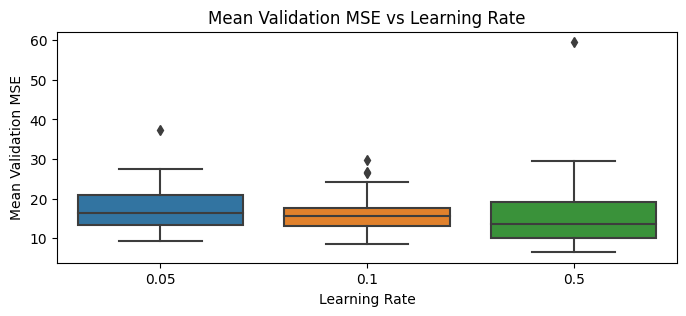

Learning Rate
0.05    7.601
0.10    6.586
0.50    6.408
Name: Test MSE, dtype: float64


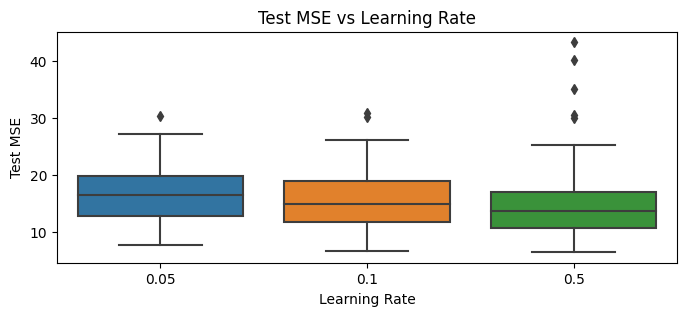

In [ ]:
# validation mse
print(housing_param_search_results_df.groupby('Learning Rate')['Mean Validation MSE'].min())
plt.figure(figsize=(8,3))
sns.boxplot(x='Learning Rate', y='Mean Validation MSE', data=housing_param_search_results_df)
plt.title('Mean Validation MSE vs Learning Rate')
plt.show()

# test mse
print(housing_param_search_results_df.groupby('Learning Rate')['Test MSE'].min())
plt.figure(figsize=(8,3))
sns.boxplot(x='Learning Rate', y='Test MSE', data=housing_param_search_results_df)
plt.title('Test MSE vs Learning Rate')
plt.show()

### Logistic Regression

In [ ]:
PARAM_GRID = {
    'IQR_FACTOR': [1.0, 1.5, 2.0],
    'BATCH_SIZE': [1, 8, 16, 32],
    'LEARNING_RATE': [0.05, 0.1, 0.5, 0.7],
    'MAX_ITERS': [1e4, 1e5],
    'MOMENTUM': [0.0, 0.5, 0.9]
}
TEST_SIZE = 0.20

print(f"Number of combinations: {len(list(product(*PARAM_GRID.values())))}")

wine_df = WINE_DF.copy()

count = 1
wine_param_search_results = []

for params in product(*PARAM_GRID.values()):
    IQR_FACTOR = params[0]
    OPTIMIZER_KWARGS = {
        'batch_size': params[1],
        'learning_rate': params[2],
        'max_iters': params[3],
        'beta': params[4],
        'verbose': False
    }

    ### Data Cleaning ###
    wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)

    ### Data Splitting ###
    one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
    X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(), 
                                                                        one_hot_wine_classes, test_size=TEST_SIZE, random_state=SEED)
    
    acc_train = []
    acc_val = []
    
    for X_train_fold, y_train_fold, X_test_fold, y_test_fold in k_fold_split(X_wine_train, y_wine_train, n_splits=3):

        log_reg = LogisticRegression()

        start_time = time.time()
        log_reg.fit(X_train_fold, y_train_fold, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
        end_time = time.time()

        y_preds_sgd_train = log_reg.predict(X_train_fold)
        y_preds_sgd_val = log_reg.predict(X_test_fold)
        acc_train.append(accuracy_score(y_train_fold, y_preds_sgd_train))
        acc_val.append(accuracy_score(y_test_fold, y_preds_sgd_val))

    log_reg = LogisticRegression()
    log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
    acc_test = accuracy_score(y_wine_test, log_reg.predict(X_wine_test))

    # save results
    param_dict = dict(zip(PARAM_GRID.keys(), params))
    result_dict = {
        'IQR Factor': param_dict['IQR_FACTOR'],
        'Batch Size': param_dict['BATCH_SIZE'],
        'Learning Rate': param_dict['LEARNING_RATE'],
        'Max Iters': param_dict['MAX_ITERS'],
        'Momentum': param_dict['MOMENTUM'],
        'Mean Train Accuracy': np.mean(acc_train).round(3),
        'Mean Validation Accuracy': np.mean(acc_val).round(3),
        'Test Accuracy': acc_test.round(3),
        'Convergence Speed': np.round((end_time - start_time), 4)
    }
    wine_param_search_results.append(result_dict)

    print(f"{count}: Params: {params}, Mean Val Acc: {np.mean(acc_val).round(3)}, Test Acc: {acc_test.round(3)}, Speed: {np.round((end_time - start_time), 4)}s")
    count += 1

Number of combinations: 288
1: Params: (1.0, 1, 0.05, 10000.0, 0.0), Mean Val Acc: 0.605, Test Acc: 0.583, Speed: 1.2373s
2: Params: (1.0, 1, 0.05, 10000.0, 0.5), Mean Val Acc: 0.533, Test Acc: 0.667, Speed: 1.2571s
3: Params: (1.0, 1, 0.05, 10000.0, 0.9), Mean Val Acc: 0.541, Test Acc: 0.625, Speed: 1.2608s


KeyboardInterrupt: 

In [8]:
# TODO plot results for different parameters
wine_param_search_results_df = pd.DataFrame(wine_param_search_results)

# save results
wine_param_search_results_df.to_csv('results/6/param_search_wine.csv', index=False)

wine_param_search_results_df.sort_values(by='Mean Validation Accuracy', ascending=False).head(20)

IQR Factor  Batch Size  Learning Rate  Max Iters  Momentum  \
51         1.0          16           0.05   100000.0       0.0   
94         1.0          32           0.70   100000.0       0.5   
88         1.0          32           0.50   100000.0       0.5   
47         1.0           8           0.70   100000.0       0.9   
76         1.0          32           0.05   100000.0       0.5   
82         1.0          32           0.10   100000.0       0.5   
59         1.0          16           0.10   100000.0       0.9   
53         1.0          16           0.05   100000.0       0.9   
40         1.0           8           0.50   100000.0       0.5   
75         1.0          32           0.05   100000.0       0.0   
87         1.0          32           0.50   100000.0       0.0   
46         1.0           8           0.70   100000.0       0.5   
33         1.0           8           0.10   100000.0       0.0   
52         1.0          16           0.05   100000.0       0.5   
77         1.0          32           0.05   100000.0       0.9   
63         1.0          16           0.50   100000.0       0.0   
81         1.0          32           0.10   100000.0       0.0   
69         1.0          16           0.70   100000.0       0.0   
95         1.0          32           0.70   100000.0       0.9   
58         1.0          16           0.10   100000.0       0.5   

    Mean Train Accuracy  Mean Validation Accuracy  Test Accuracy  \
51                0.979                     0.947          0.917   
94                1.000                     0.947          0.917   
88                0.957                     0.947          0.875   
47                0.941                     0.946          0.958   
76                0.963                     0.936          0.958   
82                0.958                     0.936          0.958   
59                0.937                     0.926          0.833   
53                0.984                     0.926          0.917   
40                0.957                     0.925          0.792   
75                0.925                     0.925          0.875   
87                0.942                     0.915          0.833   
46                0.963                     0.906          0.917   
33                0.952                     0.906          0.750   
52                0.984                     0.904          0.917   
77                0.952                     0.904          0.833   
63                0.894                     0.904          0.958   
81                0.957                     0.904          0.583   
69                0.963                     0.904          0.833   
95                0.958                     0.904          0.917   
58                0.862                     0.894          0.958   

    Convergence Speed  
51             8.6666  
94             9.3232  
88             8.9085  
47             8.5213  
76             8.9553  
82             9.0466  
59             9.1458  
53             8.7146  
40             8.2571  
75             8.9454  
87             9.0673  
46             8.4215  
33             8.3486  
52             8.7045  
77             9.0942  
63             8.6016  
81             9.2947  
69             8.6875  
95             9.4164  
58             8.6399

### Results

**Linear Regression**
- Best Params: 
    - IQR factor: 1.0
    - Batch Size: 32
    - Learning Rate: 0.5
    - Max Epochs: 100000
    - Momentum: 0.5
    - Test MSE: 5.778

**Logistic Regression**
- x

# Experiment 7: Gaussian Basis Functions

Only for dataset1, Gaussian Basis Functions:
- Utilize Gaussian basis functions to enrich the feature set for Dataset 1. • Define each Gaussian basis function as follows:
  
$$\phi_j(x) = exp(-\frac{||x-\mu_j||^2}{2s^2})$$

- Employ a total of 5 Gaussian basis functions.
- Set the spatial scale parameter, s, to a value of 1.
- Select μj values randomly from the training set to determine the centers of these basis functions.
- Use analytical linear regression to predict the target value.
- Compare the target and predicted values obtained with the new dataset with the results obtained with the original feature set, i.e. compare with the results obtained without Gaussian basis functions.

### Data Preparation

In [22]:
IQR_FACTOR = 1.5
TEST_SIZE = 0.2

housing_df = HOUSING_DF.copy()

temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

### Data Splitting ###
X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), test_size=TEST_SIZE)

In [23]:

def gaussian_basis(x, mu_values, s=1.0):
    return [np.exp(-np.linalg.norm(x - mu)**2 / (2 * s**2)) for mu in mu_values]

def sigmoid_basis(x, mu_values, s=1.0):
    return [1/(1 + np.exp(-(x - mu) / s)) for mu in mu_values]


def add_nonlinear_features(X_housing_train, X_housing_test, feature_index, basis_fn, num_basis_functions=5):

    def compute_basis_features(X, feature_index, param_values, basis_fn):
        num_samples = X.shape[0]
        basis_features = np.empty((num_samples, num_basis_functions))
        for i in range(num_samples):
            basis_features[i] = basis_fn(X[i, feature_index], param_values)
        return basis_features
    
    # select random indices to use as mu values
    param_values = np.random.choice(np.unique(X_housing_train[:, feature_index]), num_basis_functions, replace=False)

    # Augment the dataset using the given basis function
    basis_functions_train = compute_basis_features(X_housing_train, feature_index, param_values, basis_fn)
    X_housing_train_aug = np.hstack((X_housing_train, basis_functions_train))
    basis_functions_test = compute_basis_features(X_housing_test, feature_index, param_values, basis_fn)
    X_housing_test_aug = np.hstack((X_housing_test, basis_functions_test))
    return X_housing_train_aug, X_housing_test_aug


gaussian_feature_index = list(housing_df.columns).index('ZN')
X_housing_train_gaussian, X_housing_test_gaussian = add_nonlinear_features(X_housing_train, X_housing_test, gaussian_feature_index, gaussian_basis)

sigmoid_feature_index = list(housing_df.columns).index('DIS')
X_housing_train_sigmoid, X_housing_test_sigmoid = add_nonlinear_features(X_housing_train, X_housing_test, sigmoid_feature_index, sigmoid_basis)

X_housing_train_comb, X_housing_test_comb = add_nonlinear_features(X_housing_train_sigmoid, X_housing_test_sigmoid, gaussian_feature_index, gaussian_basis)

### Linear Regression

In [25]:
### Original Features ###
lin_reg = LinearRegression()
lin_reg.fit(X_housing_train, y_housing_train, analytic_fit=True, verbose=False)
ms_error_analytic_train = mse(y_housing_train, lin_reg.predict(X_housing_train))
ms_error_analytic = mse(y_housing_test, lin_reg.predict(X_housing_test))


### With Gaussian Basis Functions ###
lin_reg = LinearRegression()
lin_reg.fit(X_housing_train_gaussian, y_housing_train, analytic_fit=True, verbose=False)
y_preds_analytic_gaussian = lin_reg.predict(X_housing_test_gaussian)
y_preds_analytic_gaussian_train = lin_reg.predict(X_housing_train_gaussian)
ms_error_analytic_gaussian = mse(y_housing_test, y_preds_analytic_gaussian)
ms_error_analytic_gaussian_train = mse(y_housing_train, y_preds_analytic_gaussian_train)

### With Sigmoid Basis Functions ###
lin_reg = LinearRegression()
lin_reg.fit(X_housing_train_sigmoid, y_housing_train, analytic_fit=True, verbose=False)
ms_error_analytic_sigmoid_train = mse(y_housing_train, lin_reg.predict(X_housing_train_sigmoid))
ms_error_analytic_sigmoid = mse(y_housing_test, lin_reg.predict(X_housing_test_sigmoid))

### With Gaussian and Sigmoid Basis Functions ###
lin_reg = LinearRegression()
lin_reg.fit(X_housing_train_comb, y_housing_train, analytic_fit=True, verbose=False)
ms_error_analytic_comb_train = mse(y_housing_train, lin_reg.predict(X_housing_train_comb))
ms_error_analytic_comb = mse(y_housing_test, lin_reg.predict(X_housing_test_comb))



print("Original Features:")
print(f"Analytic Fit MSE train: {ms_error_analytic_train:.5f}")
print(f"Analytic Fit MSE test: {ms_error_analytic:.5f}")

print("\nWith Gaussian Basis Functions:")
print(f"Analytic Fit MSE train: {ms_error_analytic_gaussian_train:.5f}")
print(f"Analytic Fit MSE test: {ms_error_analytic_gaussian:.5f}")

print("\nWith Sigmoid Basis Functions:")
print(f"Analytic Fit MSE train: {ms_error_analytic_sigmoid_train:.5f}")
print(f"Analytic Fit MSE test: {ms_error_analytic_sigmoid:.5f}")

print("\nWith Sigmoid and Gaussian Basis Functions:")
print(f"Analytic Fit MSE train: {ms_error_analytic_comb_train:.5f}")
print(f"Analytic Fit MSE test: {ms_error_analytic_comb:.5f}")

Original Features:
Analytic Fit MSE train: 6.17920
Analytic Fit MSE test: 8.51491

With Gaussian Basis Functions:
Analytic Fit MSE train: 5.99688
Analytic Fit MSE test: 8.00070

With Sigmoid Basis Functions:
Analytic Fit MSE train: 5.93278
Analytic Fit MSE test: 7.51599

With Sigmoid and Gaussian Basis Functions:
Analytic Fit MSE train: 5.41358
Analytic Fit MSE test: 8.40242
Data & Original & Original + Gaussian & Original + Sigmoid & Original + Gaussian + Sigmoid
Train & 6.17920 & 5.99688 & 5.93278 & 5.41358
Train & 8.51491 & 8.00070 & 7.51599 & 8.40242


### Results

- adding Gaussian Basis Functions improved the SGD fit very slightly 
- significantly decreased the analytic fit
- in this specific context, may not be helpful when using an analytic method

# Experiment 8: Analytical vs. Mini-Batch Stochastic Gradient Descent
Only for dataset1, Compare analytical linear regression solution with mini-batch stochastic gradient descent- based linear regression solution. What do you find? Why do you think mini-batch stochastic gradient descent is used when an analytical solution is available?

In [ ]:
# TODO: plot mse over timie

### Results

- we can use results from experiments before
- SGD is much faster than analytical solution
- more flexibility in terms of SGD, tuning hyperparameters to the specific problem
- SGD can be used for much larger datasets